## 딥러닝을 사용한 시계열 데이터 예측 


(클래식 머신러닝과 성능비교, transfer learning  적용하여)


# 목차 

1. 프로젝트 목적 및 진행절차 소개 (데이터, 가설, 평가지표 소개)
2. 기준모델
3. Deep Learning 기법 적용 및 성능 비교 
      
*   모델 구성법 (학습/타겟 데이터 window 생성)
*   모델1.Simple RNN
*   모델2.LSTM
*   모델3.GRU
*   모델4. transformer

4. Transfer Learning 적용 및 비교 
*  Sorce Data
*   LSTM (재학습x ,1층, 2층)
*   GRU (재학습x,1층, 2층)
*   transformer (재학습 x, 1층)

5. 결론 및 한계점




#1. 프로젝트 목적 및 진행절차 소개 (데이터, 가설, 평가지표 소개)


# 1-1) 프로젝트 목적

시계열 데이터 분석을 위해 모델별 성능 비교 평가 

# 1-2) 진행 절차 

1) 이전에 진행한 classic 머신러닝 ( linear regression ,random forest regressor , XGB boosting emd) 으로 기준모델 생성

2) 딥러닝 (Simple RNN, LSTM, GRU, transfoermer) 적용, 하이퍼 파라미터 튜닝 후 성능 비교

3) Trasnfer Learning적용 후 성능 비교

# 1-3) 가설


가설1- deep learning 이 좀 더 성능이 좋겠지만, 큰 차이 없을 것이다.

근거- Application of machine learning techniques for supply chain demand forecasting (2008)



가설2 - 도메인이 다르더라도 다른 시계열 데이터로 transfer learning할 시 성능이 조금 항상될 것이다.

근거- computer vision 에서 다른 도메인의 task도 transfer larning 시 성능향상에 기여하는 것을 착안 



# 1-4) 데이터 소개 

데이터: Walmart Weekly Sales Data


데이터 수집 기간: 2010-02-05 to 2012-11-01


변수: 16개 Store, Dept, 공휴일 유무(Super Bowl, Labor Day, Thanksgiving, Christmas), 기온, Markdown, CPI, 실업률, 유가

데이터 사이즈 : 143rows 
(원본데이터 421,570 rows * 17 columns,  동일한 날짜에 store/ dept 별 다른 데이터가 있으나, 프로젝트의 목적은 변수 별이 아닌 시간 별 sales data 예측 이므로 날짜별로 축소)

*데이터 EDA 따로 진행했으며, 해당 데이터의 특성을 잘 나타내 주는 아래 두 자료만 가져왔습니다.
(좌) average weekly sales by per year ( 주별 판매량이 년도별로 비슷한 트렌드를 보여줍니다)
(우) weekly sales 와 다른 변수 간 상관관계(절대값)

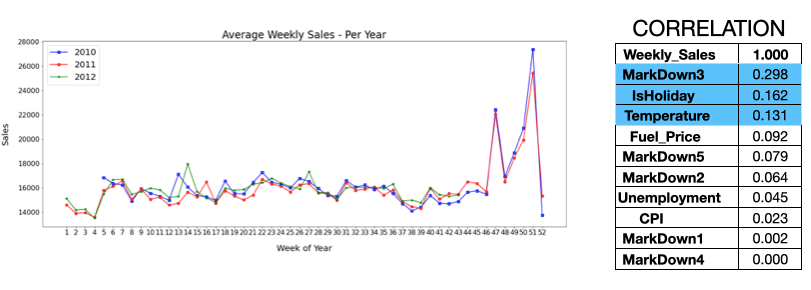

# 1-5) 평가 지표 

주 평가 지표 MAE (Mean Absolute Error) - 예상치와 실제값의 차이 절대값의 평균


선정 이유:공휴일/ 피크시즌의 세일즈가 폭발할 경우 이상치로 잡지 않고, 좀 더 직관적인 평가가 가능하므로 선정


보조 평가지표 MSE

In [139]:
#라이브러리 

!pip install category_encoders
!pip install finance-datareader #삼성 주식 정보 
!pip install tensorflow==2.7.0 #개발환경
!pip install keras_tuner

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import FinanceDataReader as fdr
import tensorflow as tf

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Conv1D, Lambda, Dropout
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, Huber
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint    

#hyper parameter tuning


import keras.metrics
import keras_tuner as kt



In [140]:
print(tf.__version__)

2.7.0



#HYPER #  2. 기준모델 
XGB Boosting Regressor (mae: 1026.4929 mse: 1518400.5)

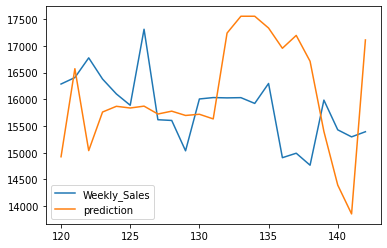




Random Forest Regressor (mae: 1038.08203125 mse: 1806367.25)



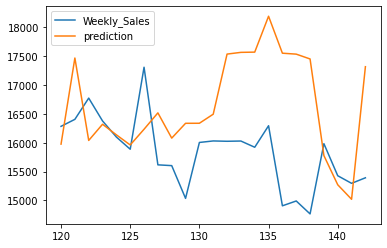


In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
import os, sys

In [143]:
cd /content/drive/MyDrive/CodeStates/Section2/dataset/walmart-recruiting-store-sales-forecasting

/content/drive/MyDrive/CodeStates/Section2/dataset/walmart-recruiting-store-sales-forecasting


In [144]:
#local 에서 업로드 
#from google.colab import files
#uploaded= files.upload()

In [145]:
train_rev

,Weekly_Sales,IsHoliday
Date,,
2010-02-05,16836.121997,False
2010-02-12,16352.056032,True
2010-02-19,16216.658979,False
2010-02-26,14899.549688,False
2010-03-05,15921.015727,False
...,...,...
2012-09-28,14765.327279,False
2012-10-05,15983.413747,False
2012-10-12,15427.596739,False


In [146]:
#데이터 불러오기 
train_rev=pd.read_csv("train_rev.csv", index_col="Date")
features_rev=pd.read_csv("features_rev.csv",index_col="Date")
df=train_rev.merge(features_rev,on="Date",how="inner")
cols=df.columns
df=df.fillna(0)
df['IsHoliday']=df['IsHoliday_x'].replace({True:1,False:0})
df=df.drop(["IsHoliday_x","IsHoliday_y"],axis=1)
#train & test 데이터 나누기 
train,test=train_test_split(df,test_size=0.16,shuffle=False)
#x ,y 데이터 분리 
target='Weekly_Sales'
y_train=train[target]
X_train=train.drop(target,axis=1)
y_test=test[target]
X_test=test.drop(target,axis=1)


In [147]:
#xgb boosting regressor
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBRegressor(max_depth=10)
)

pipe.fit(X_train, y_train);
y_train_pred=pipe.predict(X_train)
y_test_pred=pipe.predict(X_test)

print("훈련데이터")
print("MAE:",mean_absolute_error(y_train,y_train_pred),"MSE:",mean_squared_error(y_train,y_train_pred),"R2:",r2_score(y_train,y_train_pred))

print("테스트데이터")
print("MAE:",mean_absolute_error(y_test,y_test_pred),"MSE:",mean_squared_error(y_test,y_test_pred),"R2:",r2_score(y_test,y_test_pred))

[05:40:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
훈련데이터
MAE: 18.513876045242174 MSE: 985.8124100915205 R2: 0.9997332796221747
테스트데이터
MAE: 586.9088043368271 MSE: 547334.1939810104 R2: -0.4904853627495702


In [148]:
# 예측값 vs 실제값 비교 그래프
def pred_plot(preds):
  actual_pred = pd.DataFrame(columns = ['Weekly_Sales', 'prediction'])
  actual_pred['Weekly_Sales']=df.Weekly_Sales.iloc[120:][0:len(preds)]
  actual_pred['prediction']=preds
  y_true = actual_pred['Weekly_Sales']
  y_pred = actual_pred['prediction']

  print(y_true[:2])
  print(y_pred[:2])
  print("len comp(true vs pred):",len(y_true),len(y_pred))
  mae = MeanAbsoluteError()
  mse = MeanSquaredError()
  result=mae(y_true,y_pred).numpy()
  result2=mse(y_true,y_pred).numpy()
  return print("mae:",result,"mse:",result2,actual_pred.plot())

Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: Weekly_Sales, dtype: float64
Date
2012-05-25    17410.591797
2012-06-01    15409.819336
Name: prediction, dtype: float32
len comp(true vs pred): 23 23
mae: 586.90894 mse: 547334.44 AxesSubplot(0.125,0.125;0.775x0.755)


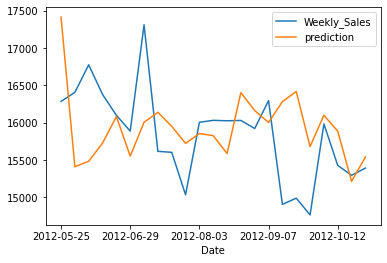

In [149]:
# xgbosst regressor 예측 그래프
pred_plot(y_test_pred)

In [150]:
# Random Forest Regressor
pipe=make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    MinMaxScaler(),
    RandomForestRegressor(
        random_state=2,n_jobs=-1,max_depth=15,
        n_estimators=30,min_samples_split=10,
        min_samples_leaf=2,max_samples=0.8,max_features=7)
)

pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_train)
y_test_pred=pipe.predict(X_test)


print("훈련데이터")
print("MAE:",mean_absolute_error(y_train,y_train_pred),"MSE:",mean_squared_error(y_train,y_train_pred),"R2:",r2_score(y_train,y_train_pred))

print("테스트데이터")
print("MAE:",mean_absolute_error(y_test,y_test_pred),"MSE:",mean_squared_error(y_test,y_test_pred),"R2:",r2_score(y_test,y_test_pred))


훈련데이터
MAE: 18.513876045242174 MSE: 985.8124100915205 R2: 0.9997332796221747
테스트데이터
MAE: 461.67266450132394 MSE: 361720.6479099056 R2: 0.014972320306539055


Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: Weekly_Sales, dtype: float64
Date
2012-05-25    17209.172991
2012-06-01    15642.049696
Name: prediction, dtype: float64
len comp(true vs pred): 23 23
mae: 461.67266845703125 mse: 361720.65625 AxesSubplot(0.125,0.125;0.775x0.755)


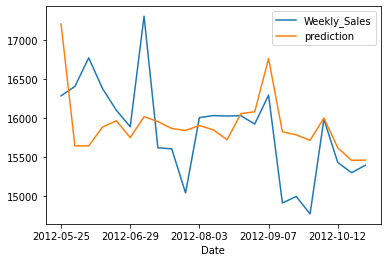

In [151]:
#random forest regressor 그래프
pred_plot(y_test_pred)

# 3. Deep Learning 기법 적용 및 성능 비교 (RNN, LSTM, GRU)


# 3-1)모델 구성법 (학습/타겟 데이터 window 생성)

In [152]:
def WindowGenerator_normalize(all_data,time_steps,for_periods):
    '''
    all data: 분리 하기 위하는 데이터 (날짜 + weekly sales) 
      data: dataframe with dates and price data
    output:
      X_train, y_train, X_test, y_test :  학습과 테스트는 전체데이터의 16%비율로 분할 (120)
      sc: 스케일러 MinMaxScaler 객체
    '''
    # 학습/ 테스트 셋 생성 (다른 변수 포함없이, x&y모두 weekly sales만 포함)
    ts_train = train_rev.iloc[:120,:1].values
    ts_test  = train_rev.iloc[120:,:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # 데이터 스케일 (매우 중요) , train data만 사용해 transform (매우중요)
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # [시계열 데이터 분석의 핵심] - 몇 time steps데이터를 보고 몇 for_periods 를 예측할지 학습/테스트 데이터 생성
    X_train = []
    y_train = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling - 
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((train_rev["Weekly_Sales"].iloc[:120], train_rev["Weekly_Sales"].iloc[120:]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

        # Preparing X_test
    X_test = []
    y_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        y_test.append(inputs[i:i+for_periods,0])
        
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, y_test, sc

In [153]:
X_train, y_train, X_test, y_test, sc = WindowGenerator_normalize(train_rev,5,1)

In [154]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((114, 5, 1), (114, 1), (22, 5, 1), (22, 1))

In [155]:
ts_train = train_rev.iloc[:120,:1].values
ts_train.shape
ts_train_sc=sc.transform(ts_train)

In [156]:
ts_test = train_rev.iloc[120:,:1].values
ts_test.shape
ts_test_sc=sc.transform(ts_test)

In [157]:
pd.DataFrame(ts_test_sc).tail

<bound method NDFrame.tail of            0
0   0.200957
1   0.209685
2   0.236222
3   0.207667
4   0.187582
5   0.172347
6   0.274777
7   0.152848
8   0.151867
9   0.110958
10  0.180810
11  0.182700
12  0.182287
13  0.182598
14  0.174823
15  0.201697
16  0.101678
17  0.107709
18  0.091548
19  0.179278
20  0.139247
21  0.129749
22  0.136663>

In [158]:
# X_train, y_train 데이터 확인하기
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see=pd.DataFrame(y_train)
pd.concat([X_train_see,y_train_see],axis=1)

,0,1,2,3,4,0
0,0.240693,0.205829,0.196077,0.101215,0.174784,0.147836
1,0.205829,0.196077,0.101215,0.174784,0.147836,0.129104
2,0.196077,0.101215,0.174784,0.147836,0.129104,0.106714
3,0.101215,0.174784,0.147836,0.129104,0.106714,0.259599
4,0.174784,0.147836,0.129104,0.106714,0.259599,0.184116
...,...,...,...,...,...,...
109,0.177965,0.167777,0.122528,0.129316,0.319891,0.156213
110,0.167777,0.122528,0.129316,0.319891,0.156213,0.119284
111,0.122528,0.129316,0.319891,0.156213,0.119284,0.093987
112,0.129316,0.319891,0.156213,0.119284,0.093987,0.176675


In [159]:
#text 데이터 확인 (전체 143 data, train 114, test 22)
#첫번째 y 값은 전체에서 120번째 

X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1]))) 
y_test_see=pd.DataFrame(y_test)
res=pd.concat([X_test_see,y_test_see],axis=1)
res.tail

<bound method NDFrame.tail of            0         1         2         3         4         0
0   0.119284  0.093987  0.176675  0.164917  0.170130  0.200957
1   0.093987  0.176675  0.164917  0.170130  0.200957  0.209685
2   0.176675  0.164917  0.170130  0.200957  0.209685  0.236222
3   0.164917  0.170130  0.200957  0.209685  0.236222  0.207667
4   0.170130  0.200957  0.209685  0.236222  0.207667  0.187582
5   0.200957  0.209685  0.236222  0.207667  0.187582  0.172347
6   0.209685  0.236222  0.207667  0.187582  0.172347  0.274777
7   0.236222  0.207667  0.187582  0.172347  0.274777  0.152848
8   0.207667  0.187582  0.172347  0.274777  0.152848  0.151867
9   0.187582  0.172347  0.274777  0.152848  0.151867  0.110958
10  0.172347  0.274777  0.152848  0.151867  0.110958  0.180810
11  0.274777  0.152848  0.151867  0.110958  0.180810  0.182700
12  0.152848  0.151867  0.110958  0.180810  0.182700  0.182287
13  0.151867  0.110958  0.180810  0.182700  0.182287  0.182598
14  0.110958  0.180810  0

#3-2) 모델1.Simple RNN
(mae: 489.3875 mse: 381402.8)

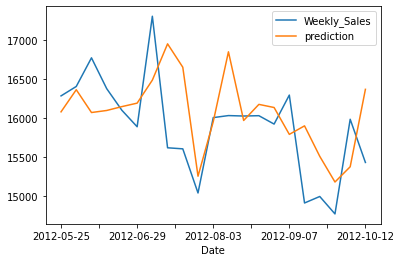


In [160]:
def simple_rnn_model(X_train, y_train, X_test, sc):
    '''
 2층 simple rnn모델 생성
    '''
    # simple rnn모델

    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # 예측 2값

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_absolute_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=1000, verbose=0)

    # predictions
    rnn_predictions = my_rnn_model.predict(X_test)
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions

In [161]:
#simple rnn

my_rnn_model, rnn_predictions= simple_rnn_model(X_train, y_train, X_test, sc)


In [162]:
rnn_predictions.shape

(22, 2)

In [163]:
y_test_reversed=sc.inverse_transform(y_test)
y_test_reversed

array([[16284.41459028],
       [16405.58943935],
       [16774.04452027],
       [16377.57466171],
       [16098.71157379],
       [15887.18449369],
       [17309.36233705],
       [15616.44041328],
       [15602.82637195],
       [15034.82951585],
       [16004.68471857],
       [16030.92696652],
       [16025.19527919],
       [16029.50121622],
       [15921.55281229],
       [16294.69295684],
       [14905.97864847],
       [14989.70838459],
       [14765.32727887],
       [15983.41374664],
       [15427.59673913],
       [15295.73239661]])

In [164]:
# 예측값 vs 실제값 비교 그래프 (x축에 날짜 나오게)

def pred_plot(preds , true):
  comp = pd.DataFrame(columns = ['true_weekly_sales', 'prediction'])
  comp['true_weekly_sales']=df.Weekly_Sales.iloc[120:-1] #이유는 모르겠으나 y_test는 마지막 값 예측 x
  comp['prediction']=preds[:,0]
  y_true = comp['true_weekly_sales']
  y_pred = comp['prediction']


  print(y_true[:2])
  print(y_pred[:2])
  print("len comp(true vs pred):",len(y_true),len(y_pred))
  mae = MeanAbsoluteError()
  mse = MeanSquaredError()
  result=mae(y_true,y_pred).numpy()
  result2=mse(y_true,y_pred).numpy()
  return print("mae:",result,"mse:",result2,comp.plot()), comp

In [165]:
my_rnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5, 32)             1088      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 5, 32)             2080      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                                 
Total params: 5,314
Trainable params: 5,314
Non-trainable params: 0
_________________________________________________________________


Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: true_weekly_sales, dtype: float64
Date
2012-05-25    15671.367188
2012-06-01    16236.072266
Name: prediction, dtype: float32
len comp(true vs pred): 22 22
mae: 590.60675 mse: 573416.1 AxesSubplot(0.125,0.125;0.775x0.755)


(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15671.367188
 2012-06-01       16405.589439  16236.072266
 2012-06-08       16774.044520  15594.816406
 2012-06-15       16377.574662  15850.950195
 2012-06-22       16098.711574  15837.177734
 2012-06-29       15887.184494  15272.065430
 2012-07-06       17309.362337  15399.500977
 2012-07-13       15616.440413  16017.697266
 2012-07-20       15602.826372  15629.428711
 2012-07-27       15034.829516  14761.553711
 2012-08-03       16004.684719  15039.158203
 2012-08-10       16030.926967  15392.355469
 2012-08-17       16025.195279  15312.600586
 2012-08-24       16029.501216  15683.762695
 2012-08-31       15921.552812  16055.601562
 2012-09-07       16294.692957  15300.212891
 2012-09-14       14905.978648  15383.465820
 2012-09-21       14989.708385  15042.796875
 2012-09-28       14765.327279  14633.183594
 2012-10-05       15983.413747  14419.829102
 201

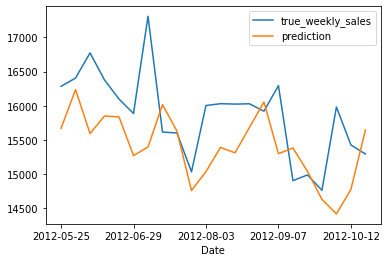

In [166]:
pred_plot(rnn_predictions, y_test_reversed_2)

In [167]:
#hyper parameter tuning

def build_model(hp):
     # simple rnn모델

    my_rnn_model = Sequential()
    #number of layers?
    for i in range(hp.Int("num_layers", 1, 3)):
      my_rnn_model.add((SimpleRNN(units=hp.Int("units", min_value = 32, max_value = 128, step=32), 
                                  return_sequences=True,
                     activation=hp.Choice("activation",["relu","tanh"])
                     )))

    #my_rnn_model.add(SimpleRNN(units=hp.Int("units", min_value = 32, max_value = 512, step=32), return_sequences=True,
                     #activation=hp.Choice("activation",["relu","tanh"])))
    #my_rnn_model.add(SimpleRNN(units=hp.Int("units", min_value = 32, max_value = 512, step=32), return_sequences=True,
    #                 activation=hp.Choice("activation",["relu","tanh"])))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(units=hp.Int("units", min_value = 32, max_value = 512, step=32), return_sequences=True, 
    #                 activation=hp.Choice("activation",["relu","tanh"])))
    my_rnn_model.add(Dense(1)) # 예측 2값 -> 1 ->다시 2로 바꿈

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_absolute_error', metrics=[keras.metrics.MeanAbsoluteError()])

    return my_rnn_model

In [168]:
#모델이 제대로 build 됐는지 확인하기 
build_model(kt.HyperParameters())

In [169]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective=kt.Objective("val_mean_absolute_error","min"),
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="simplernn",
)

In [170]:
tuner.search(X_train,y_train, epochs=2, validation_data=(X_test, y_test))

Trial 3 Complete [00h 00m 06s]
val_mean_absolute_error: 0.059261051937937737

Best val_mean_absolute_error So Far: 0.05028806999325752
Total elapsed time: 00h 00m 18s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [171]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}


In [172]:
tuner.results_summary()

Results summary
Results in my_dir/simplernn
Showing 10 best trials
Objective(name='val_mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 2
units: 32
activation: tanh
Score: 0.05028806999325752
Trial summary
Hyperparameters:
num_layers: 1
units: 64
activation: relu
Score: 0.056096483021974564
Trial summary
Hyperparameters:
num_layers: 2
units: 64
activation: tanh
Score: 0.059261051937937737


In [173]:
#hyper parameter tuning이용해서 (unit , layer 수)
def simple_rnn_model_2(X_train, y_train, X_test, sc):
    '''
 2층 simple rnn모델 생성
    '''
    # simple rnn모델

    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32,activation='relu')) #return sequence 없앰
    #my_rnn_model.add(SimpleRNN(256, return_sequences=True,activation='relu'))
    my_rnn_model.add(Dense(1)) # 예측 2값 ->1

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_absolute_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=1000, verbose=0)

    # predictions
    rnn_predictions_2 = my_rnn_model.predict(X_test)
    rnn_predictions_2 = sc.inverse_transform(rnn_predictions_2)

    return my_rnn_model, rnn_predictions_2

In [174]:
my_rnn_model, rnn_predictions_2 = simple_rnn_model_2(X_train, y_train, X_test, sc)

In [175]:
y_test_reversed_2=sc.inverse_transform(y_test) # pred plot 에서 더 직관적으로 보기 위해

In [176]:
y_test_reversed_2.shape

(22, 1)

In [177]:
rnn_predictions_2

array([[15734.9   ],
       [16806.195 ],
       [15453.737 ],
       [15821.891 ],
       [15796.285 ],
       [15663.1875],
       [15819.54  ],
       [16313.851 ],
       [15226.163 ],
       [15049.259 ],
       [15193.979 ],
       [15735.928 ],
       [15580.666 ],
       [15471.557 ],
       [16261.857 ],
       [15144.978 ],
       [15415.434 ],
       [14336.3125],
       [14572.987 ],
       [14780.387 ],
       [15653.257 ],
       [15539.509 ]], dtype=float32)

In [178]:
rnn_predictions_2.shape

(22, 1)

In [179]:
df.Weekly_Sales.iloc[120:].shape

(23,)

Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: true_weekly_sales, dtype: float64
Date
2012-05-25    15734.900391
2012-06-01    16806.195312
Name: prediction, dtype: float32
len comp(true vs pred): 22 22
mae: 570.75977 mse: 476183.72 AxesSubplot(0.125,0.125;0.775x0.755)


(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15734.900391
 2012-06-01       16405.589439  16806.195312
 2012-06-08       16774.044520  15453.737305
 2012-06-15       16377.574662  15821.890625
 2012-06-22       16098.711574  15796.285156
 2012-06-29       15887.184494  15663.187500
 2012-07-06       17309.362337  15819.540039
 2012-07-13       15616.440413  16313.850586
 2012-07-20       15602.826372  15226.163086
 2012-07-27       15034.829516  15049.258789
 2012-08-03       16004.684719  15193.978516
 2012-08-10       16030.926967  15735.927734
 2012-08-17       16025.195279  15580.666016
 2012-08-24       16029.501216  15471.556641
 2012-08-31       15921.552812  16261.857422
 2012-09-07       16294.692957  15144.977539
 2012-09-14       14905.978648  15415.433594
 2012-09-21       14989.708385  14336.312500
 2012-09-28       14765.327279  14572.987305
 2012-10-05       15983.413747  14780.386719
 201

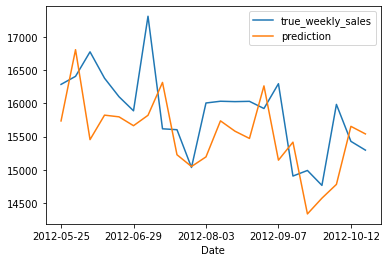

In [180]:
pred_plot(rnn_predictions_2, y_test_reversed_2)

In [181]:
#optimizer tuner

def rnn_model(X_train, y_train, X_test, y_test, sc, optimizer, saving_path) :
    '''
 2층 simple rnn모델 생성
    '''
    # simple rnn모델

    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32,activation='relu')) #return sequence 없앰
    
    #my_rnn_model.add(SimpleRNN(256, return_sequences=True,activation='relu'))
    my_rnn_model.add(Dense(1)) # 예측 2값

    my_rnn_model.compile(optimizer=optimizer, loss='mean_absolute_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=1000, verbose=0)
        
        #save model
    
    my_rnn_model.save(saving_path)

    rnn_prediction = my_rnn_model.predict(X_test)

    return np.mean(np.square(rnn_prediction - y_test))

class MyTuner(kt.RandomSearch):
  def run_trial(self, trial, **kwargs):
    hp = trial.hyperparameters
    return rnn_model( X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test, sc=sc,
        optimizer=hp.Choice("optimizer", ["adam", "rmsprop", "Nadam"]),
        saving_path=os.path.join("/tmp", trial.trial_id),
    )

In [182]:
tuner = MyTuner(
    max_trials=3, overwrite=True, directory="my_dir", project_name="keep_code_separate",
)
tuner.search()

Trial 3 Complete [00h 00m 34s]
default_objective: 0.0017750983246269632

Best default_objective So Far: 0.0016021855629110584
Total elapsed time: 00h 01m 36s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [183]:
tuner.results_summary()

Results summary
Results in my_dir/keep_code_separate
Showing 10 best trials
Objective(name='default_objective', direction='min')
Trial summary
Hyperparameters:
optimizer: rmsprop
Score: 0.0016021855629110584
Trial summary
Hyperparameters:
optimizer: Nadam
Score: 0.0017750983246269632
Trial summary
Hyperparameters:
optimizer: adam
Score: 0.002796209672668729


Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: true_weekly_sales, dtype: float64
Date
2012-05-25    16430.781250
2012-06-01    16414.173828
Name: prediction, dtype: float32
len comp(true vs pred): 22 22
mae: 551.2418 mse: 459566.6 AxesSubplot(0.125,0.125;0.775x0.755)


(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  16430.781250
 2012-06-01       16405.589439  16414.173828
 2012-06-08       16774.044520  15566.522461
 2012-06-15       16377.574662  15651.976562
 2012-06-22       16098.711574  15230.741211
 2012-06-29       15887.184494  14864.259766
 2012-07-06       17309.362337  16054.786133
 2012-07-13       15616.440413  16382.011719
 2012-07-20       15602.826372  15047.239258
 2012-07-27       15034.829516  14060.706055
 2012-08-03       16004.684719  15924.844727
 2012-08-10       16030.926967  15716.579102
 2012-08-17       16025.195279  15759.536133
 2012-08-24       16029.501216  16543.568359
 2012-08-31       15921.552812  15992.349609
 2012-09-07       16294.692957  15124.119141
 2012-09-14       14905.978648  15217.840820
 2012-09-21       14989.708385  14373.944336
 2012-09-28       14765.327279  14432.618164
 2012-10-05       15983.413747  15312.178711
 201

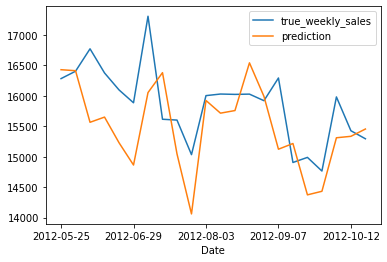

In [184]:
#hyper parameter tuning이용해서 (unit 32, layer 수 3)  ,  optimizer adam
def simple_rnn_model_2(X_train, y_train, X_test, sc):
    '''
 2층 simple rnn모델 생성
    '''
    # simple rnn모델

    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32,return_sequences=True, activation='relu'))
    my_rnn_model.add(SimpleRNN(32,activation='relu')) #return sequence 없앰
    #my_rnn_model.add(SimpleRNN(256, return_sequences=True,activation='relu'))
    my_rnn_model.add(Dense(1)) # 예측 2값 ->1

    my_rnn_model.compile(optimizer='adam', loss='mean_absolute_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=1000, verbose=0)

    # predictions
    rnn_predictions_2 = my_rnn_model.predict(X_test)
    rnn_predictions_2 = sc.inverse_transform(rnn_predictions_2)

    return my_rnn_model, rnn_predictions_2
  
my_rnn_model, rnn_predictions_2 = simple_rnn_model_2(X_train, y_train, X_test, sc)

pred_plot(rnn_predictions_2, y_test_reversed_2)

In [185]:
my_rnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 5, 32)             1088      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [186]:
X_train

array([[[0.24069279],
        [0.20582892],
        [0.19607722],
        [0.1012151 ],
        [0.17478412]],

       [[0.20582892],
        [0.19607722],
        [0.1012151 ],
        [0.17478412],
        [0.14783563]],

       [[0.19607722],
        [0.1012151 ],
        [0.17478412],
        [0.14783563],
        [0.12910412]],

       [[0.1012151 ],
        [0.17478412],
        [0.14783563],
        [0.12910412],
        [0.10671368]],

       [[0.17478412],
        [0.14783563],
        [0.12910412],
        [0.10671368],
        [0.25959869]],

       [[0.14783563],
        [0.12910412],
        [0.10671368],
        [0.25959869],
        [0.18411643]],

       [[0.12910412],
        [0.10671368],
        [0.25959869],
        [0.18411643],
        [0.13349316]],

       [[0.10671368],
        [0.25959869],
        [0.18411643],
        [0.13349316],
        [0.12660789]],

       [[0.25959869],
        [0.18411643],
        [0.13349316],
        [0.12660789],
        [0.10610

In [187]:
y_train

array([[0.14783563],
       [0.12910412],
       [0.10671368],
       [0.25959869],
       [0.18411643],
       [0.13349316],
       [0.12660789],
       [0.10610975],
       [0.21956082],
       [0.14542459],
       [0.14445162],
       [0.211331  ],
       [0.27027982],
       [0.21222695],
       [0.20071424],
       [0.17891818],
       [0.23591553],
       [0.21648501],
       [0.17620007],
       [0.13417036],
       [0.13006323],
       [0.22200734],
       [0.18366654],
       [0.19648501],
       [0.16908384],
       [0.18978354],
       [0.14718082],
       [0.08744358],
       [0.04405448],
       [0.06464406],
       [0.13452564],
       [0.08877192],
       [0.08529324],
       [0.09918488],
       [0.15348218],
       [0.16268354],
       [0.1426727 ],
       [0.6416601 ],
       [0.24702573],
       [0.38810735],
       [0.53284254],
       [1.        ],
       [0.01759564],
       [0.07958627],
       [0.02859678],
       [0.03155577],
       [0.00518615],
       [0.164

In [188]:
#weight 살펴보기 
rnn_w = my_rnn_model.get_weights()
print(my_rnn_model.get_weights())

[array([[-0.43469727,  0.02283693,  0.45264196, -0.3485062 , -0.25067404,
         0.29340845, -0.50193846, -0.3713772 , -0.42185163, -0.55910665,
         0.06205862, -0.30295202, -0.02071088, -0.42128807,  0.4757652 ,
        -0.37356833, -0.08986991,  0.21276712,  0.2122713 ,  0.5101893 ,
        -0.18139404,  0.3371872 ,  0.4225138 ,  0.0852336 ,  0.00275243,
        -0.35189158,  0.4341181 , -0.52802366,  0.03395493, -0.55685437,
         0.21961015,  0.37365627]], dtype=float32), array([[ 0.316863  ,  0.11967191,  0.26971525, ..., -0.08426353,
         0.2556033 , -0.17059743],
       [-0.14259602, -0.21652544,  0.30427048, ...,  0.11480514,
        -0.39273745,  0.2731595 ],
       [-0.15189986,  0.07572024, -0.01479415, ...,  0.12817329,
         0.06261432, -0.03830266],
       ...,
       [-0.2853491 ,  0.24344166,  0.03369718, ..., -0.09752807,
        -0.07361431,  0.4159868 ],
       [ 0.01279282, -0.09476331, -0.33003318, ..., -0.20291027,
        -0.00423999,  0.2546926 

In [189]:
pd.DataFrame(rnn_w)

,0
0,"[[-0.43469727, 0.022836933, 0.45264196, -0.348..."
1,"[[0.316863, 0.11967191, 0.26971525, 0.09257322..."
2,"[-0.012285789, 0.031776607, -0.013761515, 0.01..."
3,"[[0.030618673, -0.023879929, 0.09268939, -0.29..."
4,"[[0.36584386, 0.15230119, -0.08989754, -0.1763..."
5,"[0.001424367, 0.018062567, 0.015058972, -0.018..."
6,"[[0.31608063], [0.0030398797], [-0.39149302], ..."
7,[0.024159396]


In [190]:
len(rnn_w[0])

1

In [191]:
rnn_w[0][0]

array([-0.43469727,  0.02283693,  0.45264196, -0.3485062 , -0.25067404,
        0.29340845, -0.50193846, -0.3713772 , -0.42185163, -0.55910665,
        0.06205862, -0.30295202, -0.02071088, -0.42128807,  0.4757652 ,
       -0.37356833, -0.08986991,  0.21276712,  0.2122713 ,  0.5101893 ,
       -0.18139404,  0.3371872 ,  0.4225138 ,  0.0852336 ,  0.00275243,
       -0.35189158,  0.4341181 , -0.52802366,  0.03395493, -0.55685437,
        0.21961015,  0.37365627], dtype=float32)

In [192]:
len(rnn_w[0][0]) ,len(rnn_w[1][0])


(32, 32)

In [193]:
len(rnn_w[2])

32

In [194]:
len(rnn_w[3])

32

In [195]:
len(rnn_w[4])

32

In [196]:
X_train.shape

(114, 5, 1)

In [197]:
y_train.shape

(114, 1)

In [198]:
my_rnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 5, 32)             1088      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


# 3-2) 모델2.LSTM 

(mae: 519.5237 mse: 359547.75)

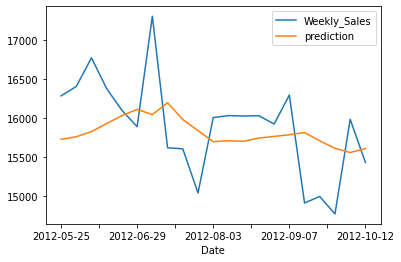

In [199]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((114, 5, 1), (114, 1), (22, 5, 1), (22, 1))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 5, 50)             20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 2)                 102       
                                                                 
Total params: 50,902
Trainable params: 50,902
Non-trainable params: 0
_________________________________________________________________
Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: true_weekly_sales, dtype: float64
Date
2012-05-25    15892.112305
2012-06-01    15903.100586
Name: prediction, dtype:

(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15892.112305
 2012-06-01       16405.589439  15903.100586
 2012-06-08       16774.044520  15795.285156
 2012-06-15       16377.574662  15874.376953
 2012-06-22       16098.711574  15887.613281
 2012-06-29       15887.184494  16089.014648
 2012-07-06       17309.362337  16134.673828
 2012-07-13       15616.440413  16182.903320
 2012-07-20       15602.826372  15882.837891
 2012-07-27       15034.829516  15825.547852
 2012-08-03       16004.684719  15794.194336
 2012-08-10       16030.926967  15839.507812
 2012-08-17       16025.195279  15806.860352
 2012-08-24       16029.501216  15850.809570
 2012-08-31       15921.552812  15859.206055
 2012-09-07       16294.692957  15707.646484
 2012-09-14       14905.978648  15728.471680
 2012-09-21       14989.708385  15647.224609
 2012-09-28       14765.327279  15588.026367
 2012-10-05       15983.413747  15571.685547
 201

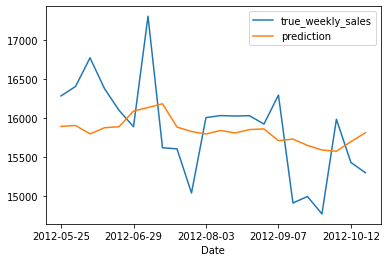

In [200]:
#LSTM (simple rnn과 동일한 optimizer)
def LSTM_model(X_train, y_train, X_test, sc):
    # LSTM구조 
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting 
    my_LSTM_model.fit(X_train,y_train,epochs=500, verbose=0)
    my_LSTM_model.summary()

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction, my_LSTM_model.summary

my_LSTM_model, LSTM_prediction, my_LSTM_model.summary = LSTM_model(X_train, y_train, X_test, sc)
pred_plot(LSTM_prediction,  y_test_reversed_2)


In [201]:
LSTM_prediction.shape

(22, 2)

Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: true_weekly_sales, dtype: float64
Date
2012-05-25    15624.359375
2012-06-01    15622.770508
Name: prediction, dtype: float32
len comp(true vs pred): 22 22
mae: 548.6797 mse: 435470.6 AxesSubplot(0.125,0.125;0.775x0.755)


(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15624.359375
 2012-06-01       16405.589439  15622.770508
 2012-06-08       16774.044520  15620.191406
 2012-06-15       16377.574662  15619.103516
 2012-06-22       16098.711574  15616.821289
 2012-06-29       15887.184494  15614.991211
 2012-07-06       17309.362337  15614.739258
 2012-07-13       15616.440413  15615.399414
 2012-07-20       15602.826372  15616.861328
 2012-07-27       15034.829516  15617.207031
 2012-08-03       16004.684719  15617.097656
 2012-08-10       16030.926967  15618.711914
 2012-08-17       16025.195279  15623.904297
 2012-08-24       16029.501216  15622.720703
 2012-08-31       15921.552812  15621.641602
 2012-09-07       16294.692957  15619.307617
 2012-09-14       14905.978648  15619.219727
 2012-09-21       14989.708385  15619.607422
 2012-09-28       14765.327279  15620.851562
 2012-10-05       15983.413747  15623.080078
 201

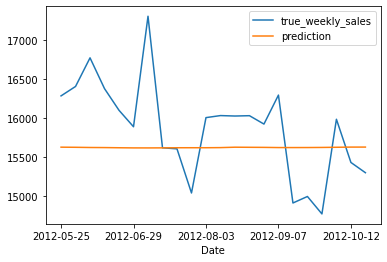

In [202]:
#LSTM (complile 옵션 다르게 적용 ) - 성능은 좋으나, 예측 값이 일관  -- > 이건 왜 그랬을까?
def LSTM_model(X_train, y_train, X_test, sc):
    # LSTM 층
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))
    # Compiling
    my_LSTM_model.compile(optimizer=SGD(lr=0.01,  momentum=0.9, nesterov=False),loss='mean_absolute_error')#decay=1e-7,#
    # Fitting 
    my_LSTM_model.fit(X_train,y_train,epochs=50, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
pred_plot(LSTM_prediction, y_test_reversed_2)

In [203]:
my_LSTM_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 50)             10400     
                                                                 
 lstm_4 (LSTM)               (None, 5, 50)             20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_7 (Dense)             (None, 2)                 102       
                                                                 
Total params: 50,902
Trainable params: 50,902
Non-trainable params: 0
_________________________________________________________________


In [204]:
#hyper parameter tuning -LSTM

def build_LSTMmodel(hp):
  
    my_LSTM_model = Sequential()
    #number of layers?
    for i in range(hp.Int("num_layers", 1, 4)):
      my_LSTM_model.add((LSTM(units=hp.Int("units", min_value = 32, max_value = 128, step=32), 
                                  return_sequences=True,
                     activation=hp.Choice("activation",["relu","tanh"])
                     )))

    #my_rnn_model.add(SimpleRNN(units=hp.Int("units", min_value = 32, max_value = 512, step=32), return_sequences=True,
                     #activation=hp.Choice("activation",["relu","tanh"])))
    #my_rnn_model.add(SimpleRNN(units=hp.Int("units", min_value = 32, max_value = 512, step=32), return_sequences=True,
    #                 activation=hp.Choice("activation",["relu","tanh"])))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(units=hp.Int("units", min_value = 32, max_value = 512, step=32), return_sequences=True, 
    #                 activation=hp.Choice("activation",["relu","tanh"])))
    my_LSTM_model.add(Dense(1)) # 예측 2값 -> 1 ->다시 2로 바꿈 -> 다시 1로 바꿈

    my_LSTM_model.compile(optimizer='rmsprop', loss='mean_absolute_error', metrics=[keras.metrics.MeanAbsoluteError()])

    return my_LSTM_model

In [205]:
build_LSTMmodel(kt.HyperParameters())

In [206]:
tuner = kt.RandomSearch(
    hypermodel=build_LSTMmodel,
    objective=kt.Objective("val_mean_absolute_error","min"),
    max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="lstm",
)

In [207]:
tuner.search(X_train,y_train, epochs=2, validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 05s]
val_mean_absolute_error: 0.11268433928489685

Best val_mean_absolute_error So Far: 0.06582873687148094
Total elapsed time: 00h 00m 51s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [208]:
tuner.results_summary()

Results summary
Results in my_dir/lstm
Showing 10 best trials
Objective(name='val_mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 2
units: 128
activation: tanh
Score: 0.06582873687148094
Trial summary
Hyperparameters:
num_layers: 2
units: 64
activation: tanh
Score: 0.06708139181137085
Trial summary
Hyperparameters:
num_layers: 3
units: 64
activation: relu
Score: 0.08564324304461479
Trial summary
Hyperparameters:
num_layers: 1
units: 64
activation: relu
Score: 0.09900656715035439
Trial summary
Hyperparameters:
num_layers: 1
units: 32
activation: relu
Score: 0.11268433928489685


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 5, 96)             37632     
                                                                 
 lstm_2 (LSTM)               (None, 96)                74112     
                                                                 
 dense_1 (Dense)             (None, 1)                 97        
                                                                 
Total params: 111,841
Trainable params: 111,841
Non-trainable params: 0
_________________________________________________________________
Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: true_weekly_sales, dtype: float64
Date
2012-05-25    15619.343750
2012-06-01    15736.249023
Name: prediction, dtype: float32
len comp(true vs pred): 22 22
mae: 526.0389 mse: 369557.78 AxesSubplot(0.125,0.125;0.775x0.755)


(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15619.343750
 2012-06-01       16405.589439  15736.249023
 2012-06-08       16774.044520  15813.260742
 2012-06-15       16377.574662  16002.898438
 2012-06-22       16098.711574  16049.373047
 2012-06-29       15887.184494  16051.199219
 2012-07-06       17309.362337  15919.076172
 2012-07-13       15616.440413  16412.589844
 2012-07-20       15602.826372  15808.873047
 2012-07-27       15034.829516  15566.671875
 2012-08-03       16004.684719  15331.729492
 2012-08-10       16030.926967  15516.899414
 2012-08-17       16025.195279  15685.811523
 2012-08-24       16029.501216  15627.760742
 2012-08-31       15921.552812  15656.446289
 2012-09-07       16294.692957  15640.576172
 2012-09-14       14905.978648  15766.934570
 2012-09-21       14989.708385  15272.975586
 2012-09-28       14765.327279  15164.911133
 2012-10-05       15983.413747  15230.527344
 201

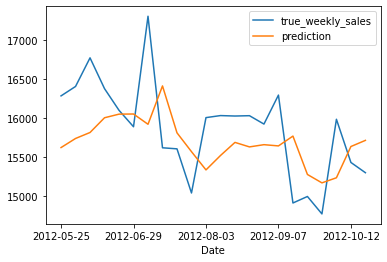

In [209]:
#LSTM , hyperparameter tuning값 사용해서 layer 4, unit 64,activation - tanh
def LSTM_model(X_train, y_train, X_test, sc):
    # LSTM구조 
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=96, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=96, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=1))

    # Compiling
    my_LSTM_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting 
    my_LSTM_model.fit(X_train,y_train,epochs=500, verbose=0)
    my_LSTM_model.summary()

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction, my_LSTM_model.summary

my_LSTM_model, LSTM_prediction, my_LSTM_model.summary = LSTM_model(X_train, y_train, X_test, sc)
pred_plot(LSTM_prediction, y_test_reversed_2)


In [210]:
#optimizer tuner

def LSTM_model(X_train, y_train, X_test, y_test, sc, optimizer, saving_path):
    # LSTM구조 
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=96, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=96, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=1))

    # Compiling
    my_LSTM_model.compile(optimizer=optimizer, loss='mean_absolute_error')
    # Fitting 
    my_LSTM_model.fit(X_train,y_train,epochs=500, verbose=0)
 
    #save model
    
    my_LSTM_model.save(saving_path)

    LSTM_prediction = my_LSTM_model.predict(X_test)

    return np.mean(np.square(LSTM_prediction - y_test))


class MyTuner(kt.RandomSearch):
  def run_trial(self, trial, **kwargs):
    hp = trial.hyperparameters
    return LSTM_model( X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test, sc=sc,
        optimizer=hp.Choice("optimizer", ["adam", "rmsprop", "Nadam"]),
        saving_path=os.path.join("/tmp", trial.trial_id),
    )

In [211]:
tuner = MyTuner(
    max_trials=3, overwrite=True, directory="my_dir", project_name="keep_code_separate",
)
tuner.search()

Trial 3 Complete [00h 00m 26s]
default_objective: 0.002198657767441134

Best default_objective So Far: 0.0018617141071674572
Total elapsed time: 00h 01m 20s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [212]:
tuner.results_summary()

Results summary
Results in my_dir/keep_code_separate
Showing 10 best trials
Objective(name='default_objective', direction='min')
Trial summary
Hyperparameters:
optimizer: adam
Score: 0.0018617141071674572
Trial summary
Hyperparameters:
optimizer: rmsprop
Score: 0.0021520080745765537
Trial summary
Hyperparameters:
optimizer: adam
Score: 0.002198657767441134


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 5, 64)             16896     
                                                                 
 lstm_10 (LSTM)              (None, 5, 64)             33024     
                                                                 
 lstm_11 (LSTM)              (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________
Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: true_weekly_sales, dtype: float64
Date
2012-05-25    15673.924805
2012-06-01    15674.932617
Name: prediction, dtype:

(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15673.924805
 2012-06-01       16405.589439  15674.932617
 2012-06-08       16774.044520  15824.318359
 2012-06-15       16377.574662  15951.301758
 2012-06-22       16098.711574  15981.208008
 2012-06-29       15887.184494  15959.281250
 2012-07-06       17309.362337  15846.629883
 2012-07-13       15616.440413  16388.062500
 2012-07-20       15602.826372  15888.449219
 2012-07-27       15034.829516  15552.780273
 2012-08-03       16004.684719  15374.528320
 2012-08-10       16030.926967  15669.584961
 2012-08-17       16025.195279  15695.412109
 2012-08-24       16029.501216  15691.093750
 2012-08-31       15921.552812  15635.052734
 2012-09-07       16294.692957  15672.639648
 2012-09-14       14905.978648  15758.635742
 2012-09-21       14989.708385  15451.381836
 2012-09-28       14765.327279  15311.916992
 2012-10-05       15983.413747  15351.338867
 201

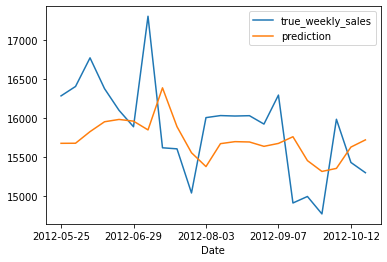

In [213]:
#LSTM , hyperparameter tuning + optimizer 값 사용해서 layer 4, unit 64,activation - tanh, adam
def LSTM_model(X_train, y_train, X_test, sc):
    # LSTM구조 
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=64, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=1))

    # Compiling
    my_LSTM_model.compile(optimizer='adam', loss='mean_absolute_error')
    # Fitting 
    my_LSTM_model.fit(X_train,y_train,epochs=500, verbose=0)
    my_LSTM_model.summary()

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction, my_LSTM_model.summary

my_LSTM_model, LSTM_prediction, my_LSTM_model.summary = LSTM_model(X_train, y_train, X_test, sc)
pred_plot(LSTM_prediction, y_test_reversed_2)

# 3-2) 모델3.GRU

(mae: 478.45493 mse: 335184.06)

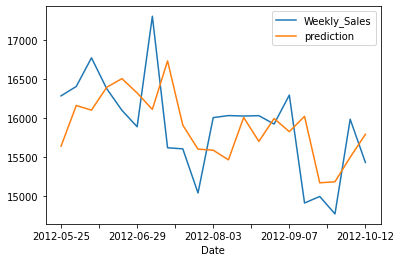



Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: true_weekly_sales, dtype: float64
Date
2012-05-25    15425.726562
2012-06-01    15416.548828
Name: prediction, dtype: float32
len comp(true vs pred): 22 22
mae: 649.09564 mse: 592110.06 AxesSubplot(0.125,0.125;0.775x0.755)


(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15425.726562
 2012-06-01       16405.589439  15416.548828
 2012-06-08       16774.044520  15401.853516
 2012-06-15       16377.574662  15396.705078
 2012-06-22       16098.711574  15385.235352
 2012-06-29       15887.184494  15376.932617
 2012-07-06       17309.362337  15377.833008
 2012-07-13       15616.440413  15386.125977
 2012-07-20       15602.826372  15383.710938
 2012-07-27       15034.829516  15384.646484
 2012-08-03       16004.684719  15389.532227
 2012-08-10       16030.926967  15401.831055
 2012-08-17       16025.195279  15420.205078
 2012-08-24       16029.501216  15415.180664
 2012-08-31       15921.552812  15408.364258
 2012-09-07       16294.692957  15397.200195
 2012-09-14       14905.978648  15398.229492
 2012-09-21       14989.708385  15395.273438
 2012-09-28       14765.327279  15402.940430
 2012-10-05       15983.413747  15416.041016
 201

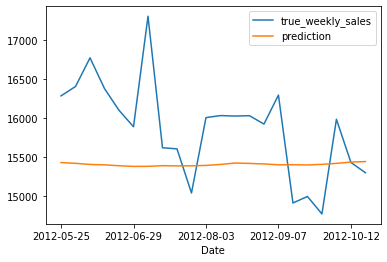

In [214]:
#GRU (시계열 GRU 모델 추천 hyper parameter적용 )
def GRU_model(X_train, y_train, X_test, sc):

    # 모델
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    # Compiling  
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mean_absolute_error')
    
    # Fitting
    my_GRU_model.fit(X_train, y_train, epochs = 50, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction 

my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
pred_plot(GRU_prediction, y_test_reversed_2)

Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: true_weekly_sales, dtype: float64
Date
2012-05-25    15411.805664
2012-06-01    15891.090820
Name: prediction, dtype: float32
len comp(true vs pred): 22 22
mae: 490.77167 mse: 329018.88 AxesSubplot(0.125,0.125;0.775x0.755)


(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15411.805664
 2012-06-01       16405.589439  15891.090820
 2012-06-08       16774.044520  15950.459961
 2012-06-15       16377.574662  16198.216797
 2012-06-22       16098.711574  16380.767578
 2012-06-29       15887.184494  16243.064453
 2012-07-06       17309.362337  16184.053711
 2012-07-13       15616.440413  16609.750000
 2012-07-20       15602.826372  16147.050781
 2012-07-27       15034.829516  15442.211914
 2012-08-03       16004.684719  15765.710938
 2012-08-10       16030.926967  15527.298828
 2012-08-17       16025.195279  15735.276367
 2012-08-24       16029.501216  15507.547852
 2012-08-31       15921.552812  15795.000977
 2012-09-07       16294.692957  15757.014648
 2012-09-14       14905.978648  15902.170898
 2012-09-21       14989.708385  15295.529297
 2012-09-28       14765.327279  15048.556641
 2012-10-05       15983.413747  15354.111328
 201

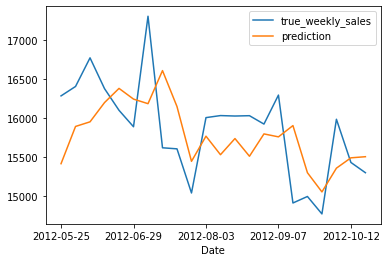

In [215]:
#GRU (simple rnn 에 적용한 compiling 적용)
def GRU_model(X_train, y_train, X_test, sc):

    # GRU Architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    # Compiling
    my_GRU_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
    my_GRU_model.fit(X_train,y_train,epochs=500, verbose=0)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train, y_train, epochs = 50, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction 

my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
pred_plot(GRU_prediction, y_test_reversed_2)

In [216]:
my_GRU_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 5, 50)             7950      
                                                                 
 gru_3 (GRU)                 (None, 50)                15300     
                                                                 
 dense_7 (Dense)             (None, 2)                 102       
                                                                 
Total params: 23,352
Trainable params: 23,352
Non-trainable params: 0
_________________________________________________________________


In [217]:
def GRU_model(X_train, y_train, X_test, y_test, sc, optimizer, saving_path, units, activation, layer, hp = kt.HyperParameters()):
    # GRU구조 
    my_GRU_model = Sequential()
    #number of layers?
    for i in range(layer):
      my_GRU_model.add(GRU(input_shape=(X_train.shape[1],1), 
                           units=units ,return_sequences = True,
                           
                     activation=activation
                     ))#return_sequences = True,
    #my_GRU_model.add(GRU(units=96, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_GRU_model.add((units=96, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_GRU_model.add(Dense(units=1))

    # Compiling
    my_GRU_model.compile(optimizer=optimizer, loss='mean_absolute_error')
    # Fitting 
    my_GRU_model.fit(X_train,y_train,epochs=500, verbose=0)
 
    #save model
    
    my_GRU_model.save(saving_path)

    GRU_prediction = my_GRU_model.predict(X_test)

    return np.mean(np.square(GRU_prediction - y_test))


class MyTuner(kt.RandomSearch):
  def run_trial(self, trial, **kwargs):
    hp = trial.hyperparameters
    return GRU_model( X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test, sc=sc,
        optimizer=hp.Choice("optimizer", ["adam", "rmsprop", "Nadam"]),
        saving_path=os.path.join("/tmp", trial.trial_id),
        units = hp.Int("units", min_value = 32, max_value = 128, step=32),
        activation = hp.Choice("activation",["relu","tanh"]),
        layer = hp.Int("num_layers", 1, 4)

    )

In [218]:
#tuner = MyTuner(
#    max_trials=3, overwrite=True, directory="my_dir", project_name="keep_code_separate",
#)
#tuner.search()

#왜 input shape이 안맞지?/ 일단 따로 해보자 - return sequences  true 나 마나 안됨

In [219]:
#tuner.results_summary()

In [220]:
#따로 다시 시도 

In [221]:
#hyper parameter tuning -GRU. -- 재 실행 필요 

def build_GRUmodel(hp):
  
    my_GRU_model = Sequential()
    #number of layers?
    for i in range(hp.Int("num_layers", 1, 4)):
      my_GRU_model.add((GRU(units=hp.Int("units", min_value = 32, max_value = 128, step=32), 
                                  return_sequences=True,
                     activation=hp.Choice("activation",["relu","tanh"])
                     )))

    #my_rnn_model.add(SimpleRNN(units=hp.Int("units", min_value = 32, max_value = 512, step=32), return_sequences=True,
                     #activation=hp.Choice("activation",["relu","tanh"])))
    #my_rnn_model.add(SimpleRNN(units=hp.Int("units", min_value = 32, max_value = 512, step=32), return_sequences=True,
    #                 activation=hp.Choice("activation",["relu","tanh"])))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(units=hp.Int("units", min_value = 32, max_value = 512, step=32), return_sequences=True, 
    #                 activation=hp.Choice("activation",["relu","tanh"])))
    my_GRU_model.add(Dense(1)) # 예측 2값 -> 1 ->다시 2로 바꿈 -> 다시 1로 바꿈

    my_GRU_model.compile(optimizer='rmsprop', loss='mean_absolute_error', metrics=[keras.metrics.MeanAbsoluteError()])

    return my_GRU_model

In [222]:
build_GRUmodel(kt.HyperParameters())

In [223]:
tuner = kt.RandomSearch(
    hypermodel=build_GRUmodel,
    objective=kt.Objective("val_mean_absolute_error","min"),
    max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="GRU",
)

In [224]:
tuner.search(X_train,y_train, epochs=2, validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 17s]
val_mean_absolute_error: 0.059153998270630836

Best val_mean_absolute_error So Far: 0.05128720961511135
Total elapsed time: 00h 01m 12s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [225]:
tuner.results_summary()

Results summary
Results in my_dir/GRU
Showing 10 best trials
Objective(name='val_mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 2
units: 96
activation: relu
Score: 0.05128720961511135
Trial summary
Hyperparameters:
num_layers: 3
units: 128
activation: relu
Score: 0.05291260406374931
Trial summary
Hyperparameters:
num_layers: 4
units: 64
activation: tanh
Score: 0.05645037069916725
Trial summary
Hyperparameters:
num_layers: 2
units: 64
activation: relu
Score: 0.05665246397256851
Trial summary
Hyperparameters:
num_layers: 4
units: 96
activation: relu
Score: 0.059153998270630836


In [226]:
X_train.shape

(114, 5, 1)

Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: true_weekly_sales, dtype: float64
Date
2012-05-25    15546.023438
2012-06-01    15557.851562
Name: prediction, dtype: float32
len comp(true vs pred): 22 22
mae: 569.9177 mse: 465119.0 AxesSubplot(0.125,0.125;0.775x0.755)


(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15546.023438
 2012-06-01       16405.589439  15557.851562
 2012-06-08       16774.044520  15567.815430
 2012-06-15       16377.574662  15580.970703
 2012-06-22       16098.711574  15582.140625
 2012-06-29       15887.184494  15574.389648
 2012-07-06       17309.362337  15563.528320
 2012-07-13       15616.440413  15583.442383
 2012-07-20       15602.826372  15571.344727
 2012-07-27       15034.829516  15555.542969
 2012-08-03       16004.684719  15533.872070
 2012-08-10       16030.926967  15537.509766
 2012-08-17       16025.195279  15547.688477
 2012-08-24       16029.501216  15554.900391
 2012-08-31       15921.552812  15558.341797
 2012-09-07       16294.692957  15556.867188
 2012-09-14       14905.978648  15562.255859
 2012-09-21       14989.708385  15540.973633
 2012-09-28       14765.327279  15522.832031
 2012-10-05       15983.413747  15508.326172
 201

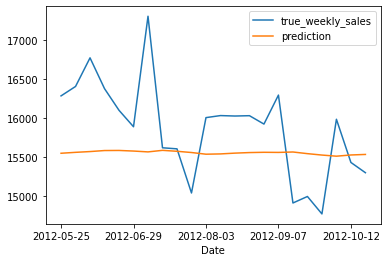

In [227]:
#GRU (시계열 GRU 모델 추천 hyper parameter적용 ) #대체 그림이 왜이럴까?
def GRU_model(X_train, y_train, X_test, sc):

    # 모델
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 96, 
                         input_shape = (X_train.shape[1],1), 
                         return_sequences = True,
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 96, 
                          input_shape = (X_train.shape[1],1),
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling  
    my_GRU_model.compile(optimizer = 'SGD', 
                         loss = 'mean_absolute_error')
    
    # Fitting
    my_GRU_model.fit(X_train, y_train, epochs = 50, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction 

my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
pred_plot(GRU_prediction, y_test_reversed_2)

In [228]:
#optimizer 찾기 
def GRU_model(X_train, y_train, X_test, y_test, sc, optimizer, saving_path):
    # GRU구조 
    my_GRU_model = Sequential()

    my_GRU_model.add(GRU(units = 96, 
                         input_shape = (X_train.shape[1],1), 
                         return_sequences = True,
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 96, 
                          input_shape = (X_train.shape[1],1),
                         activation = 'tanh'))

    my_GRU_model.add(Dense(units=1))

    # Compiling
    my_GRU_model.compile(optimizer=optimizer, loss='mean_absolute_error')
    # Fitting 
    my_GRU_model.fit(X_train,y_train,epochs=500, verbose=0)
 
    #save model
    
    my_GRU_model.save(saving_path)

    GRU_prediction = my_GRU_model.predict(X_test)

    return np.mean(np.square(GRU_prediction - y_test))


class MyTuner(kt.RandomSearch):
  def run_trial(self, trial, **kwargs):
    hp = trial.hyperparameters
    return GRU_model( X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test, sc=sc,
        optimizer=hp.Choice("optimizer", ["adam", "rmsprop", "Nadam"]),
        saving_path=os.path.join("/tmp", trial.trial_id))


In [229]:
tuner = MyTuner(
    max_trials=3, overwrite=True, directory="my_dir", project_name="keep_code_separate",
)
tuner.search()

Trial 3 Complete [00h 00m 26s]
default_objective: 0.001753745719129387

Best default_objective So Far: 0.0016728060742738219
Total elapsed time: 00h 01m 19s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [230]:
tuner.results_summary()

Results summary
Results in my_dir/keep_code_separate
Showing 10 best trials
Objective(name='default_objective', direction='min')
Trial summary
Hyperparameters:
optimizer: Nadam
Score: 0.0016728060742738219
Trial summary
Hyperparameters:
optimizer: rmsprop
Score: 0.001753745719129387
Trial summary
Hyperparameters:
optimizer: adam
Score: 0.0018424774991908407


Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: true_weekly_sales, dtype: float64
Date
2012-05-25    15789.056641
2012-06-01    15804.002930
Name: prediction, dtype: float32
len comp(true vs pred): 22 22
mae: 525.44055 mse: 404319.38 AxesSubplot(0.125,0.125;0.775x0.755)


(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15789.056641
 2012-06-01       16405.589439  15804.002930
 2012-06-08       16774.044520  15749.902344
 2012-06-15       16377.574662  15802.471680
 2012-06-22       16098.711574  15699.540039
 2012-06-29       15887.184494  15567.193359
 2012-07-06       17309.362337  15497.905273
 2012-07-13       15616.440413  15742.774414
 2012-07-20       15602.826372  15587.447266
 2012-07-27       15034.829516  15486.615234
 2012-08-03       16004.684719  15373.488281
 2012-08-10       16030.926967  15532.340820
 2012-08-17       16025.195279  15761.899414
 2012-08-24       16029.501216  15764.367188
 2012-08-31       15921.552812  15730.062500
 2012-09-07       16294.692957  15622.904297
 2012-09-14       14905.978648  15678.638672
 2012-09-21       14989.708385  15466.180664
 2012-09-28       14765.327279  15411.960938
 2012-10-05       15983.413747  15425.092773
 201

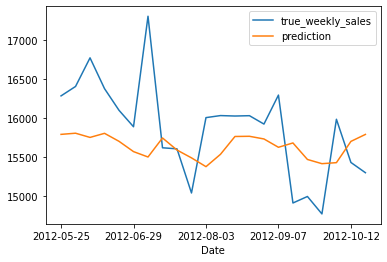

In [231]:
#optimizer tuning후 모델 (layer 2, unit 64, tanh, adam)

#GRU (시계열 GRU 모델 추천 hyper parameter적용 ) #대체 그림이 왜이럴까?
def GRU_model(X_train, y_train, X_test, sc):

    # 모델
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 64, 
                         input_shape = (X_train.shape[1],1), 
                         return_sequences = True,
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 64, 
                          input_shape = (X_train.shape[1],1),
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling  
    my_GRU_model.compile(optimizer = 'adam', 
                         loss = 'mean_absolute_error')
    
    # Fitting
    my_GRU_model.fit(X_train, y_train, epochs = 50, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction 

my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
pred_plot(GRU_prediction, y_test_reversed_2)

In [232]:
my_GRU_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 5, 64)             12864     
                                                                 
 gru_13 (GRU)                (None, 64)                24960     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________


In [233]:
# Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [234]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [235]:
input_shape = X_train.shape[1:]

trans_model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

trans_model.compile(
    loss="mean_absolute_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_absolute_error"],
)
trans_model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

trans_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

trans_model.evaluate(X_test, y_test, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 1)]       0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 5, 1)        2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 5, 1)        7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

[0.03824857249855995, 0.03824857249855995]

Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: true_weekly_sales, dtype: float64
Date
2012-05-25    15707.363281
2012-06-01    15696.041016
Name: prediction, dtype: float32
len comp(true vs pred): 22 22
mae: 531.061 mse: 413761.72 AxesSubplot(0.125,0.125;0.775x0.755)


(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15707.363281
 2012-06-01       16405.589439  15696.041016
 2012-06-08       16774.044520  15678.186523
 2012-06-15       16377.574662  15654.336914
 2012-06-22       16098.711574  15651.003906
 2012-06-29       15887.184494  15646.985352
 2012-07-06       17309.362337  15665.436523
 2012-07-13       15616.440413  15644.909180
 2012-07-20       15602.826372  15676.312500
 2012-07-27       15034.829516  15656.020508
 2012-08-03       16004.684719  15718.736328
 2012-08-10       16030.926967  15709.177734
 2012-08-17       16025.195279  15722.073242
 2012-08-24       16029.501216  15693.259766
 2012-08-31       15921.552812  15689.388672
 2012-09-07       16294.692957  15685.262695
 2012-09-14       14905.978648  15677.748047
 2012-09-21       14989.708385  15708.808594
 2012-09-28       14765.327279  15715.599609
 2012-10-05       15983.413747  15766.339844
 201

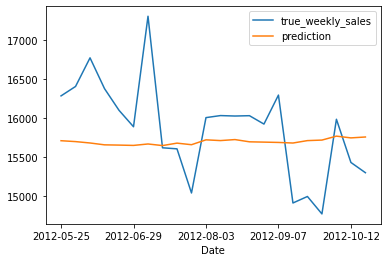

In [236]:
pred = trans_model.predict(X_test)
pred = sc.inverse_transform(pred)

pred_plot(pred, y_test_reversed_2)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 1)]       0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 5, 1)        2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 5, 1)        7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15719.934570
 2012-06-01       16405.589439  15703.747070
 2012-06-08       16774.044520  15678.868164
 2012-06-15       16377.574662  15652.940430
 2012-06-22       16098.711574  15649.736328
 2012-06-29       15887.184494  15644.713867
 2012-07-06       17309.362337  15662.866211
 2012-07-13       15616.440413  15638.839844
 2012-07-20       15602.826372  15677.405273
 2012-07-27       15034.829516  15660.160156
 2012-08-03       16004.684719  15721.645508
 2012-08-10       16030.926967  15707.942383
 2012-08-17       16025.195279  15728.998047
 2012-08-24       16029.501216  15700.939453
 2012-08-31       15921.552812  15696.914062
 2012-09-07       16294.692957  15687.665039
 2012-09-14       14905.978648  15678.572266
 2012-09-21       14989.708385  15717.636719
 2012-09-28       14765.327279  15723.848633
 2012-10-05       15983.413747  15775.109375
 201

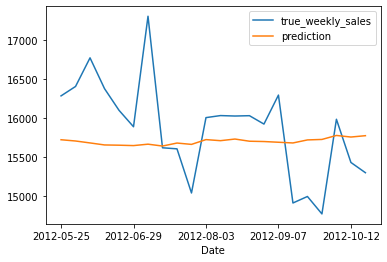

In [237]:
#transformer learning rate default 

trans_model.compile(
    loss="mean_absolute_error",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mean_absolute_error"],
)
trans_model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

trans_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

trans_model.evaluate(X_test, y_test, verbose=1)

pred = trans_model.predict(X_test)
pred = sc.inverse_transform(pred)

pred_plot(pred, y_test_reversed_2)

주식 데이터 모델로 transfer learning 시도 







#    4. Transfer Learning 적용 및 비교

비교적 개수가 많은 시계열 데이터인 주식 정보를 sorce domain으로 사용(종목: 삼성전자, 수집기간: 1990-2020, 개수:6,000개 ),

 주식 데이터를 학습한 model 을 sales forecasting에 전이학습 시도 했습니다.

# 4-1) Source model (삼성전자 가격 예상 모델)

In [238]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [239]:
#주식 데이터 가져 오기 , datareader를 활용해 연, 월,일로 나누기 
stock = fdr.DataReader(STOCK_CODE)
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [282]:
df2.size

30000

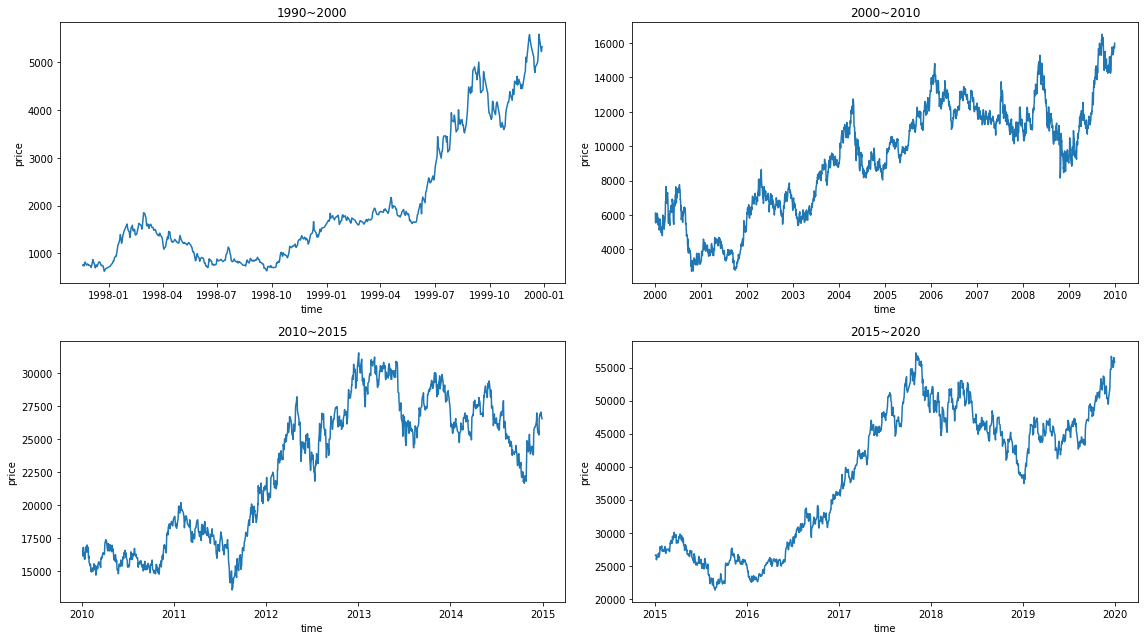

In [240]:
#데이터 살펴보기 (df2)
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df2 = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df2['Close'], x=df2.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

In [241]:
#데이터 스케일링
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
df2 = pd.DataFrame(scaled, columns=scale_cols)
# train, test분할
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(df2.drop('Close', 1), df2['Close'], test_size=0.2, random_state=0, shuffle=False)

In [242]:
X_train_s

,Open,High,Low,Volume
0,0.008106,0.007913,0.008000,0.004070
1,0.008361,0.007986,0.008179,0.004049
2,0.008583,0.008027,0.007944,0.005419
3,0.008826,0.008233,0.008480,0.006100
4,0.009391,0.008781,0.009084,0.005244
...,...,...,...,...
4795,0.436545,0.413223,0.440447,0.003370
4796,0.441860,0.412190,0.440894,0.003985
4797,0.437874,0.409711,0.436190,0.003134
4798,0.438538,0.409711,0.437989,0.003329


In [243]:
y_train_s

0       0.001427
1       0.001560
2       0.001228
3       0.001881
4       0.002158
          ...   
4795    0.434566
4796    0.429697
4797    0.425935
4798    0.428590
4799    0.429697
Name: Close, Length: 4800, dtype: float64

In [244]:
#TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성 #한번더 확인 필요 
def windowed_dataset(series, window_size, batch_size, shuffle):
  """
    window size=3이면 3일 주가 보고, 다음날 예측
    stride - window를 한칸식 건너 뛰면서 묶겠다. 
    drop_remainder - window생성시 남는 데이터를 어떻게 처리할지 -> 크기 일치시키기 위해 true로 설정
    shuffle(buffer_size)데이터 셋 섞기 ,30000개 데이터에서 버퍼사이즈가 1000이라면 0~999인덱스 사이즈 중 랜덤 추출
    prefetch -미리 데이터를 fetch. (병렬 처리 하기 때문에 학습 속도 개선)
    prefetch(1)시 다음 데이터 만들어, 1번 학습 시  병렬 적으로 뒤에 배치를 만듬 , 미리 만들어서 바로 학습
    """
  series = tf.expand_dims(series, axis=-1) # 기능 확인 필요 
  ds = tf.data.Dataset.from_tensor_slices(series) # numpy array(series)를 넣으면 data set class 로 변경,  dataset이 구현가능한 함수 사용 위해
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True) #window set을 짜를 때는 size , size+1 (y)까지 자름
    
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  if shuffle:
      ds = ds.shuffle(1000)
  ds = ds.map(lambda w: (w[:-1], w[-1])) #(x(window 사이즈 개수),y)
  return ds.batch(batch_size).prefetch(1)

In [245]:
#hyper parameter - 5일치 학습
WINDOW_SIZE=5
BATCH_SIZE=32

In [246]:
# trian_data_s는 학습용 데이터셋, test_data_s는 검증용 데이터셋 
train_data_s = windowed_dataset(y_train_s, WINDOW_SIZE, BATCH_SIZE, False)
test_data_s = windowed_dataset(y_test_s, WINDOW_SIZE, BATCH_SIZE, False)

In [247]:
#데이터 확인해보기 
train_data_s

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>

In [248]:
# 데이터 셋 잘 구성 됐는지 확인
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data_s.take(1): #take 1- 한 개의 batch 만
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 5, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [249]:
#삼성전자 시계열 예측 (original) 
model = Sequential([
#     1차원 feature map 생성
     Conv1D(filters=32, kernel_size=5,
            padding="causal",
            activation="relu",input_shape=[WINDOW_SIZE, 1]),
#     LSTM - original 동일하게 모델 층 수정 (12.17)
     Dense(16, activation="relu"),
     LSTM(16, activation='tanh'),
     Dense(16, activation="relu"),
     Dense(1),
 ])
 # Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용
loss = Huber()
optimizer = Adam(0.0005) #original과 동일하게  learning rate수정 
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)
history = model.fit(train_data_s, 
                    validation_data=(test_data_s), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

pred= model.predict(test_data_s)

model.summary()

Epoch 1/50
    150/Unknown - 4s 8ms/step - loss: 2.6734e-04 - mse: 5.3469e-04
Epoch 00001: val_loss improved from inf to 0.02100, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 5s 17ms/step - loss: 2.6734e-04 - mse: 5.3469e-04 - val_loss: 0.0210 - val_mse: 0.0420
Epoch 2/50
143/150 [===========================>..] - ETA: 0s - loss: 0.0018 - mse: 0.0036
Epoch 00002: val_loss improved from 0.02100 to 0.01615, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 2s 10ms/step - loss: 0.0018 - mse: 0.0035 - val_loss: 0.0161 - val_mse: 0.0323
Epoch 3/50
146/150 [============================>.] - ETA: 0s - loss: 9.9089e-04 - mse: 0.0020
Epoch 00003: val_loss improved from 0.01615 to 0.00471, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 1s 10ms/step - loss: 9.7944e-04 - mse: 0.0020 - val_loss: 0.0047 - val_mse: 0.0094
Epoch 4/50
143/150 [===========================>..] - ETA: 0s - loss: 3.8167e-04

In [250]:
model.load_weights(filename)
pred = model.predict(test_data_s)

In [251]:
pred.shape

(1195, 1)

mae: 0.15655164 mse 0.043026816


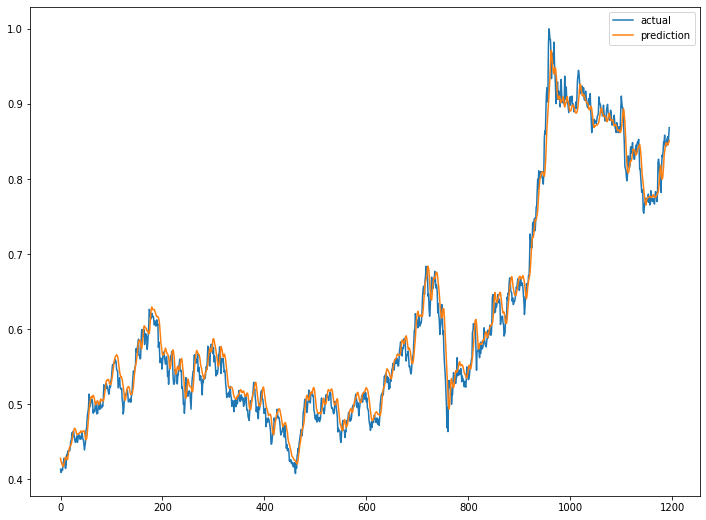

In [252]:
#예측 데이터 시각화
#지표
mae=MeanAbsoluteError()
mse=MeanSquaredError()
result=mae(y_test_s[5:],pred).numpy()
result2=mse(y_test_s[5:],pred).numpy()
print("mae:",result,"mse",result2)

#그래프
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test_s)[5:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [253]:
#model save
if os.path.isfile('models/stock_model.h5') is False:
  model.save('models/stock_model.h5')

# 4-2) 수요예측 LSTM 모델에 적용 (재학습x)

(mae: 517.8713 mse: 398747.2)

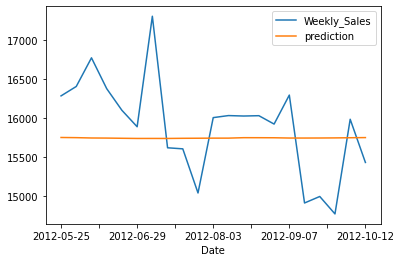

Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: true_weekly_sales, dtype: float64
Date
2012-05-25    15867.259766
2012-06-01    16141.207031
Name: prediction, dtype: float32
len comp(true vs pred): 22 22
mae: 490.60867 mse: 446378.28 AxesSubplot(0.125,0.125;0.775x0.755)


(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15867.259766
 2012-06-01       16405.589439  16141.207031
 2012-06-08       16774.044520  16379.537109
 2012-06-15       16377.574662  16699.251953
 2012-06-22       16098.711574  16376.606445
 2012-06-29       15887.184494  16169.900391
 2012-07-06       17309.362337  15961.087891
 2012-07-13       15616.440413  17183.644531
 2012-07-20       15602.826372  15764.179688
 2012-07-27       15034.829516  15751.721680
 2012-08-03       16004.684719  15119.183594
 2012-08-10       16030.926967  16137.172852
 2012-08-17       16025.195279  15997.459961
 2012-08-24       16029.501216  16054.000977
 2012-08-31       15921.552812  15965.481445
 2012-09-07       16294.692957  15967.910156
 2012-09-14       14905.978648  16279.316406
 2012-09-21       14989.708385  15119.188477
 2012-09-28       14765.327279  15183.183594
 2012-10-05       15983.413747  14962.352539
 201

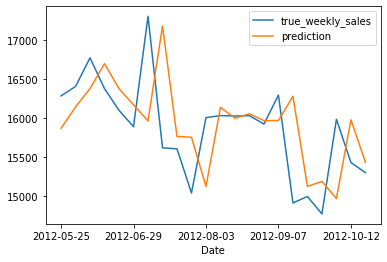

In [254]:
#LSTM (stock original optimizer)
def new_model_fun(X_train, y_train, X_test, sc):

    new_model=load_model('models/stock_model.h5')

    new_model.trainable=False
    
    # Compiling (stock original)
    new_model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

    # Fitting to the training set
    new_model.fit(X_train,y_train,epochs=500, verbose=0)

    LSTM_prediction = new_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return new_model, LSTM_prediction

new_model, LSTM_prediction = new_model_fun(X_train, y_train, X_test, sc)
pred_plot(LSTM_prediction, y_test_reversed_2)

In [255]:
new_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 32)             192       
                                                                 
 dense_12 (Dense)            (None, 5, 16)             528       
                                                                 
 lstm_32 (LSTM)              (None, 16)                2112      
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,121
Trainable params: 0
Non-trainable params: 3,121
_________________________________________________________________


Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: true_weekly_sales, dtype: float64
Date
2012-05-25    15867.259766
2012-06-01    16141.207031
Name: prediction, dtype: float32
len comp(true vs pred): 22 22
mae: 490.60867 mse: 446378.28 AxesSubplot(0.125,0.125;0.775x0.755)


(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15867.259766
 2012-06-01       16405.589439  16141.207031
 2012-06-08       16774.044520  16379.537109
 2012-06-15       16377.574662  16699.251953
 2012-06-22       16098.711574  16376.606445
 2012-06-29       15887.184494  16169.900391
 2012-07-06       17309.362337  15961.087891
 2012-07-13       15616.440413  17183.644531
 2012-07-20       15602.826372  15764.179688
 2012-07-27       15034.829516  15751.721680
 2012-08-03       16004.684719  15119.183594
 2012-08-10       16030.926967  16137.172852
 2012-08-17       16025.195279  15997.459961
 2012-08-24       16029.501216  16054.000977
 2012-08-31       15921.552812  15965.481445
 2012-09-07       16294.692957  15967.910156
 2012-09-14       14905.978648  16279.316406
 2012-09-21       14989.708385  15119.188477
 2012-09-28       14765.327279  15183.183594
 2012-10-05       15983.413747  14962.352539
 201

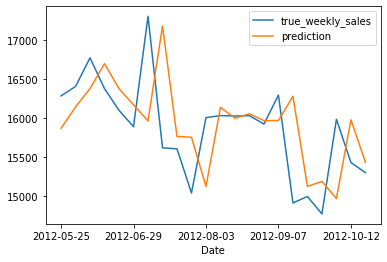

In [256]:
#LSTM (simple rnn과 동일한 optimizer)
def new_model_fun(X_train, y_train, X_test, sc):

    new_model=load_model('models/stock_model.h5')

    new_model.trainable=False
    
    # Compiling
    new_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
    new_model.fit(X_train,y_train,epochs=500, verbose=0)

    LSTM_prediction = new_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return new_model, LSTM_prediction

new_model_fun(X_train, y_train, X_test, sc)
pred_plot(LSTM_prediction,y_test_reversed_2)

In [257]:
new_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 32)             192       
                                                                 
 dense_12 (Dense)            (None, 5, 16)             528       
                                                                 
 lstm_32 (LSTM)              (None, 16)                2112      
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,121
Trainable params: 0
Non-trainable params: 3,121
_________________________________________________________________


#4-2) 수요예측 LSTM 모델에 적용 (재학습 1층)


(mae434.4138 mse: 345597.47)

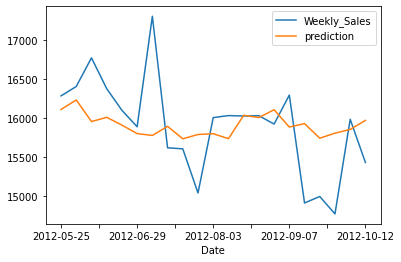

Epoch 1/500
4/4 [==============================] - 2s 5ms/step - loss: 0.0817
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0810
Epoch 3/500
4/4 [==============================] - 0s 4ms/step - loss: 0.0806
Epoch 4/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0802
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0799
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0798
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0795
Epoch 8/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0794
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0792
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0790
Epoch 11/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0789
Epoch 12/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0787
Epoch 13/500
4/4 [==============================] - 0s 5ms/st

(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15671.067383
 2012-06-01       16405.589439  15829.770508
 2012-06-08       16774.044520  15967.863281
 2012-06-15       16377.574662  16158.062500
 2012-06-22       16098.711574  15970.156250
 2012-06-29       15887.184494  15848.118164
 2012-07-06       17309.362337  15724.653320
 2012-07-13       15616.440413  16436.029297
 2012-07-20       15602.826372  15618.054688
 2012-07-27       15034.829516  15603.034180
 2012-08-03       16004.684719  15235.011719
 2012-08-10       16030.926967  15817.398438
 2012-08-17       16025.195279  15744.659180
 2012-08-24       16029.501216  15779.206055
 2012-08-31       15921.552812  15728.707031
 2012-09-07       16294.692957  15727.926758
 2012-09-14       14905.978648  15907.481445
 2012-09-21       14989.708385  15238.866211
 2012-09-28       14765.327279  15268.706055
 2012-10-05       15983.413747  15142.721680
 201

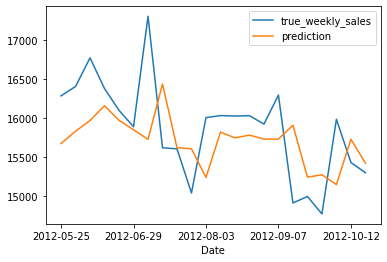

In [258]:
#LSTM에 적용 (마지막 레이어만 학습)

#LSTM (vanila rnn과 동일한 optimizer)
def new_LSTM_model(X_train, y_train, X_test, sc):

    new_model=load_model('models/stock_model.h5')
    # The LSTM architecture
    # my_LSTM_model = Sequential()
    # my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    # my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
    # #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    # my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    # my_LSTM_model.add(Dense(units=2))

    #my_LSTM_model.load_weights(stock_weight)

    new_model.layers[4].trainable = True
    new_model.layers[3].trainable = False
    new_model.layers[2].trainable = False
    new_model.layers[1].trainable = False
    new_model.layers[0].trainable = False

    # Compiling
    new_model.compile(optimizer='adam', loss='mean_absolute_error')
    # Fitting to the training set
    new_model.fit(X_train,y_train,epochs=500, verbose=1)

    LSTM_prediction = new_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return new_model, LSTM_prediction

new_model, LSTM_prediction= new_LSTM_model(X_train,y_train,X_test,sc)
pred_plot(LSTM_prediction, y_test_reversed_2)


In [259]:
new_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 32)             192       
                                                                 
 dense_12 (Dense)            (None, 5, 16)             528       
                                                                 
 lstm_32 (LSTM)              (None, 16)                2112      
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,121
Trainable params: 17
Non-trainable params: 3,104
_________________________________________________________________


# 4-2) 수요예측 LSTM 모델에 적용 (재학습 2층)

(mae: 616.5031 mse: 531686.75)

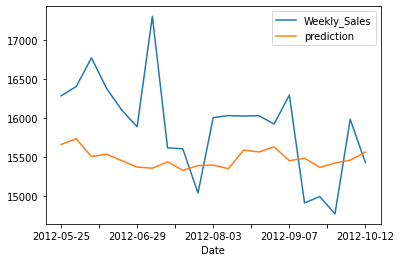

Epoch 1/500
4/4 [==============================] - 2s 6ms/step - loss: 0.0813
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0799
Epoch 3/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0791
Epoch 4/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0784
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0778
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0770
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0765
Epoch 8/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0760
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0756
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0751
Epoch 11/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0746
Epoch 12/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0742
Epoch 13/500
4/4 [==============================] - 0s 5ms/st

(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15702.828125
 2012-06-01       16405.589439  15858.936523
 2012-06-08       16774.044520  16019.034180
 2012-06-15       16377.574662  16323.765625
 2012-06-22       16098.711574  16146.815430
 2012-06-29       15887.184494  15920.953125
 2012-07-06       17309.362337  15714.777344
 2012-07-13       15616.440413  16596.652344
 2012-07-20       15602.826372  15765.818359
 2012-07-27       15034.829516  15579.378906
 2012-08-03       16004.684719  15158.023438
 2012-08-10       16030.926967  15607.496094
 2012-08-17       16025.195279  15728.180664
 2012-08-24       16029.501216  15813.758789
 2012-08-31       15921.552812  15777.055664
 2012-09-07       16294.692957  15732.151367
 2012-09-14       14905.978648  15899.094727
 2012-09-21       14989.708385  15284.568359
 2012-09-28       14765.327279  15147.938477
 2012-10-05       15983.413747  15020.768555
 201

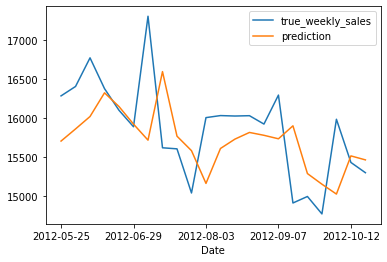

In [260]:
#LSTM BEST MODEL (마지막 2층 학습)

#LSTM (vanila rnn과 동일한 optimizer)
def LSTM_model(X_train, y_train, X_test, sc):

    new_model=load_model('models/stock_model.h5')

    new_model.layers[4].trainable = True
    new_model.layers[3].trainable = True
    new_model.layers[2].trainable = False
    new_model.layers[1].trainable = False
    new_model.layers[0].trainable = False



    # Compiling
    new_model.compile(optimizer='adam', loss='mean_absolute_error')
    # Fitting to the training set
    new_model.fit(X_train,y_train,epochs=500, verbose=1)

    LSTM_prediction = new_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return new_model, LSTM_prediction

new_model, LSTM_prediction= LSTM_model(X_train,y_train,X_test,sc)
pred_plot(LSTM_prediction, y_test_reversed_2)

In [261]:
new_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 32)             192       
                                                                 
 dense_12 (Dense)            (None, 5, 16)             528       
                                                                 
 lstm_32 (LSTM)              (None, 16)                2112      
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,121
Trainable params: 289
Non-trainable params: 2,832
_________________________________________________________________


Epoch 1/500
4/4 [==============================] - 2s 6ms/step - loss: 0.0811
Epoch 2/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0793
Epoch 3/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0776
Epoch 4/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0769
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0759
Epoch 6/500
4/4 [==============================] - 0s 7ms/step - loss: 0.0753
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0748
Epoch 8/500
4/4 [==============================] - 0s 7ms/step - loss: 0.0741
Epoch 9/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0736
Epoch 10/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0730
Epoch 11/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0727
Epoch 12/500
4/4 [==============================] - 0s 7ms/step - loss: 0.0723
Epoch 13/500
4/4 [==============================] - 0s 6ms/st

(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15443.778320
 2012-06-01       16405.589439  15587.787109
 2012-06-08       16774.044520  15821.357422
 2012-06-15       16377.574662  16247.177734
 2012-06-22       16098.711574  16033.749023
 2012-06-29       15887.184494  15841.327148
 2012-07-06       17309.362337  15670.251953
 2012-07-13       15616.440413  16913.138672
 2012-07-20       15602.826372  15542.235352
 2012-07-27       15034.829516  15488.541992
 2012-08-03       16004.684719  15038.738281
 2012-08-10       16030.926967  15629.979492
 2012-08-17       16025.195279  15477.589844
 2012-08-24       16029.501216  15491.933594
 2012-08-31       15921.552812  15496.464844
 2012-09-07       16294.692957  15531.860352
 2012-09-14       14905.978648  15756.064453
 2012-09-21       14989.708385  15353.665039
 2012-09-28       14765.327279  15229.592773
 2012-10-05       15983.413747  15236.998047
 201

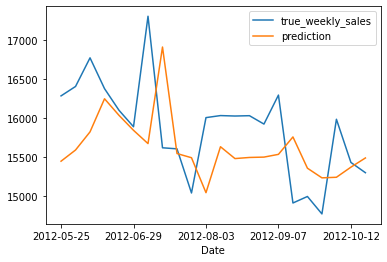

In [262]:
#LSTM BEST MODEL (마지막 2층 학습)

#LSTM (vanila rnn과 동일한 optimizer)
def LSTM_model(X_train, y_train, X_test, sc):

    new_model=load_model('models/stock_model.h5')

    new_model.layers[4].trainable = True
    new_model.layers[3].trainable = True
    new_model.layers[2].trainable = True
    new_model.layers[1].trainable = False
    new_model.layers[0].trainable = False



    # Compiling
    new_model.compile(optimizer='adam', loss='mean_absolute_error')
    # Fitting to the training set
    new_model.fit(X_train,y_train,epochs=500, verbose=1)

    LSTM_prediction = new_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return new_model, LSTM_prediction

new_model, LSTM_prediction= LSTM_model(X_train,y_train,X_test,sc)
pred_plot(LSTM_prediction, y_test_reversed_2)

In [263]:
new_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 32)             192       
                                                                 
 dense_12 (Dense)            (None, 5, 16)             528       
                                                                 
 lstm_32 (LSTM)              (None, 16)                2112      
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,121
Trainable params: 2,401
Non-trainable params: 720
_________________________________________________________________


GRU

In [264]:
#삼성전자 시계열 예측 (GRU )
model = Sequential([
#     1차원 feature map 생성
     Conv1D(filters=32, kernel_size=5,
            padding="causal",
            activation="relu",input_shape=[WINDOW_SIZE, 1]),
#     LSTM - original 동일하게 모델 층 수정 (12.17)
      Dense(16, activation="relu"),
     GRU(16, activation='tanh'),
     Dense(16, activation="relu"),
     Dense(1),
 ])
 # Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용
loss = Huber()
optimizer = Adam(0.0005) #original과 동일하게  learning rate수정 
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)
history = model.fit(train_data_s, 
                    validation_data=(test_data_s), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

pred= model.predict(test_data_s)

model.summary()

Epoch 1/50
    146/Unknown - 3s 7ms/step - loss: 2.4142e-04 - mse: 4.8284e-04
Epoch 00001: val_loss improved from inf to 0.02137, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 4s 13ms/step - loss: 2.7452e-04 - mse: 5.4903e-04 - val_loss: 0.0214 - val_mse: 0.0427
Epoch 2/50
148/150 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0032
Epoch 00002: val_loss did not improve from 0.02137
150/150 [==============================] - 1s 9ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 0.0233 - val_mse: 0.0466
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0023
Epoch 00003: val_loss improved from 0.02137 to 0.00819, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 1s 9ms/step - loss: 0.0012 - mse: 0.0023 - val_loss: 0.0082 - val_mse: 0.0164
Epoch 4/50
144/150 [===========================>..] - ETA: 0s - loss: 6.0788e-04 - mse: 0.0012
Epoch 00004: val_loss improved from 0.

In [265]:
#model save
if os.path.isfile('models/stock_model.h5') is False:
  model.save('models/stock_model.h5')

Epoch 1/500
4/4 [==============================] - 2s 5ms/step - loss: 0.0816
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0810
Epoch 3/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0805
Epoch 4/500
4/4 [==============================] - 0s 4ms/step - loss: 0.0800
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0798
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0796
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0795
Epoch 8/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0793
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0791
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0789
Epoch 11/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0788
Epoch 12/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0787
Epoch 13/500
4/4 [==============================] - 0s 6ms/st

(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15660.072266
 2012-06-01       16405.589439  15817.650391
 2012-06-08       16774.044520  15954.821289
 2012-06-15       16377.574662  16143.866211
 2012-06-22       16098.711574  15957.415039
 2012-06-29       15887.184494  15836.321289
 2012-07-06       17309.362337  15713.768555
 2012-07-13       15616.440413  16420.263672
 2012-07-20       15602.826372  15607.736328
 2012-07-27       15034.829516  15593.061523
 2012-08-03       16004.684719  15228.013672
 2012-08-10       16030.926967  15805.737305
 2012-08-17       16025.195279  15733.121094
 2012-08-24       16029.501216  15767.434570
 2012-08-31       15921.552812  15717.414062
 2012-09-07       16294.692957  15716.771484
 2012-09-14       14905.978648  15894.975586
 2012-09-21       14989.708385  15231.575195
 2012-09-28       14765.327279  15261.391602
 2012-10-05       15983.413747  15136.328125
 201

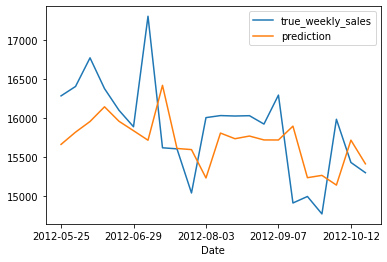

In [266]:
#GRU -마지막 한층 

#GRU
def GRU_model(X_train, y_train, X_test, sc):

    new_model=load_model('models/stock_model.h5')

    new_model.layers[4].trainable = True
    new_model.layers[3].trainable = False
    new_model.layers[2].trainable = False
    new_model.layers[1].trainable = False
    new_model.layers[0].trainable = False



    # Compiling
    new_model.compile(optimizer='adam', loss='mean_absolute_error')
    # Fitting to the training set
    new_model.fit(X_train,y_train,epochs=500, verbose=1)

    GRU_prediction = new_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return new_model, GRU_prediction

new_model, GRU_prediction= GRU_model(X_train,y_train,X_test,sc)
pred_plot(GRU_prediction, y_test_reversed_2)

In [267]:
new_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 32)             192       
                                                                 
 dense_12 (Dense)            (None, 5, 16)             528       
                                                                 
 lstm_32 (LSTM)              (None, 16)                2112      
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,121
Trainable params: 17
Non-trainable params: 3,104
_________________________________________________________________


Epoch 1/500
4/4 [==============================] - 3s 6ms/step - loss: 0.0813
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0798
Epoch 3/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0791
Epoch 4/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0787
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0781
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0774
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0767
Epoch 8/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0763
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0758
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0753
Epoch 11/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0749
Epoch 12/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0746
Epoch 13/500
4/4 [==============================] - 0s 5ms/st

(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15699.178711
 2012-06-01       16405.589439  15858.171875
 2012-06-08       16774.044520  16021.151367
 2012-06-15       16377.574662  16325.083008
 2012-06-22       16098.711574  16147.750977
 2012-06-29       15887.184494  15921.903320
 2012-07-06       17309.362337  15714.720703
 2012-07-13       15616.440413  16597.687500
 2012-07-20       15602.826372  15765.277344
 2012-07-27       15034.829516  15577.031250
 2012-08-03       16004.684719  15149.223633
 2012-08-10       16030.926967  15606.476562
 2012-08-17       16025.195279  15726.635742
 2012-08-24       16029.501216  15812.972656
 2012-08-31       15921.552812  15775.717773
 2012-09-07       16294.692957  15731.550781
 2012-09-14       14905.978648  15900.520508
 2012-09-21       14989.708385  15276.936523
 2012-09-28       14765.327279  15138.103516
 2012-10-05       15983.413747  15006.785156
 201

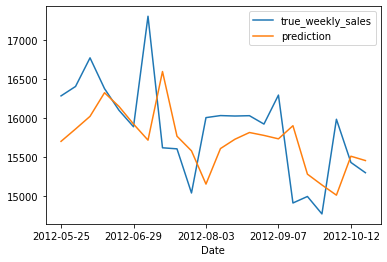

In [268]:
#GRU -마지막 두층 

#GRU
def GRU_model(X_train, y_train, X_test, sc):

    new_model=load_model('models/stock_model.h5')

    new_model.layers[4].trainable = True
    new_model.layers[3].trainable = True
    new_model.layers[2].trainable = False
    new_model.layers[1].trainable = False
    new_model.layers[0].trainable = False



    # Compiling
    new_model.compile(optimizer='adam', loss='mean_absolute_error')
    # Fitting to the training set
    new_model.fit(X_train,y_train,epochs=500, verbose=1)

    GRU_prediction = new_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return new_model, GRU_prediction

new_model, GRU_prediction= GRU_model(X_train,y_train,X_test,sc)
pred_plot(GRU_prediction, y_test_reversed_2)

In [269]:
new_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 32)             192       
                                                                 
 dense_12 (Dense)            (None, 5, 16)             528       
                                                                 
 lstm_32 (LSTM)              (None, 16)                2112      
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,121
Trainable params: 289
Non-trainable params: 2,832
_________________________________________________________________


Epoch 1/500
4/4 [==============================] - 2s 6ms/step - loss: 0.0810
Epoch 2/500
4/4 [==============================] - 0s 7ms/step - loss: 0.0785
Epoch 3/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0774
Epoch 4/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0768
Epoch 5/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0759
Epoch 6/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0750
Epoch 7/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0744
Epoch 8/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0737
Epoch 9/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0730
Epoch 10/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0727
Epoch 11/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0726
Epoch 12/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0721
Epoch 13/500
4/4 [==============================] - 0s 6ms/st

(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15498.610352
 2012-06-01       16405.589439  15632.208008
 2012-06-08       16774.044520  15869.563477
 2012-06-15       16377.574662  16306.005859
 2012-06-22       16098.711574  16086.549805
 2012-06-29       15887.184494  15891.831055
 2012-07-06       17309.362337  15718.954102
 2012-07-13       15616.440413  16987.570312
 2012-07-20       15602.826372  15587.299805
 2012-07-27       15034.829516  15541.097656
 2012-08-03       16004.684719  15248.862305
 2012-08-10       16030.926967  15690.217773
 2012-08-17       16025.195279  15520.548828
 2012-08-24       16029.501216  15534.951172
 2012-08-31       15921.552812  15538.862305
 2012-09-07       16294.692957  15577.326172
 2012-09-14       14905.978648  15805.081055
 2012-09-21       14989.708385  15428.471680
 2012-09-28       14765.327279  15306.138672
 2012-10-05       15983.413747  15320.032227
 201

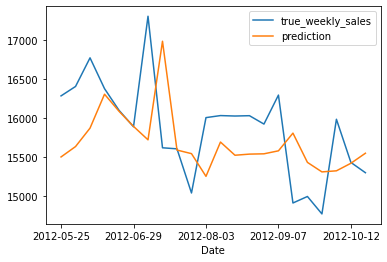

In [270]:
#GRU -마지막 세층

#GRU
def GRU_model(X_train, y_train, X_test, sc):

    new_model=load_model('models/stock_model.h5')

    new_model.layers[4].trainable = True
    new_model.layers[3].trainable = True
    new_model.layers[2].trainable = True
    new_model.layers[1].trainable = False
    new_model.layers[0].trainable = False



    # Compiling
    new_model.compile(optimizer='adam', loss='mean_absolute_error')
    # Fitting to the training set
    new_model.fit(X_train,y_train,epochs=500, verbose=1)

    GRU_prediction = new_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return new_model, GRU_prediction

new_model, GRU_prediction= GRU_model(X_train,y_train,X_test,sc)
pred_plot(GRU_prediction, y_test_reversed_2)

In [271]:
new_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 32)             192       
                                                                 
 dense_12 (Dense)            (None, 5, 16)             528       
                                                                 
 lstm_32 (LSTM)              (None, 16)                2112      
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,121
Trainable params: 2,401
Non-trainable params: 720
_________________________________________________________________


In [272]:
X_train_s.size

19200

In [273]:
#transformer

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

#input_shape = train_data_s.shape[1:]

trans_model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)


#transformer learning rate default 

trans_model.compile(
    loss="mean_absolute_error",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mean_absolute_error"],
)
trans_model.summary()

#callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

trans_model.fit(
train_data_s,
    epochs=50
)

pred = trans_model.predict(test_data_s)



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 1)]       0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 5, 1)        2           ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 5, 1)        7169        ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                                            

In [274]:
pred = trans_model.predict(test_data_s)

In [275]:
pred

array([[0.2895228 ],
       [0.2894999 ],
       [0.28948846],
       ...,
       [0.29053777],
       [0.2905498 ],
       [0.29059154]], dtype=float32)

mae: 0.31817523 mse 0.12350718


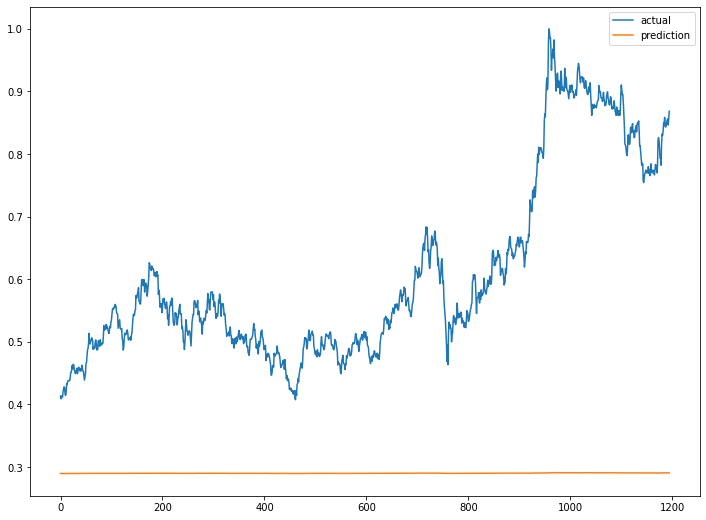

In [276]:
#예측 데이터 시각화
#지표
mae=MeanAbsoluteError()
mse=MeanSquaredError()
result=mae(y_test_s[5:],pred).numpy()
result2=mse(y_test_s[5:],pred).numpy()
print("mae:",result,"mse",result2)

#그래프
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test_s)[5:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [277]:
#model save
if os.path.isfile('trans_model/stock_model.h5') is False:
  trans_model.save('trans_model/stock_model.h5')

Epoch 1/500
4/4 [==============================] - 4s 21ms/step - loss: 0.1652
Epoch 2/500
4/4 [==============================] - 0s 18ms/step - loss: 0.1420
Epoch 3/500
4/4 [==============================] - 0s 17ms/step - loss: 0.1250
Epoch 4/500
4/4 [==============================] - 0s 17ms/step - loss: 0.1116
Epoch 5/500
4/4 [==============================] - 0s 17ms/step - loss: 0.1007
Epoch 6/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0926
Epoch 7/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0877
Epoch 8/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0816
Epoch 9/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0776
Epoch 10/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0772
Epoch 11/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0781
Epoch 12/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0770
Epoch 13/500
4/4 [==============================]

(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15837.692383
 2012-06-01       16405.589439  15840.625000
 2012-06-08       16774.044520  15832.969727
 2012-06-15       16377.574662  15834.878906
 2012-06-22       16098.711574  15831.518555
 2012-06-29       15887.184494  15826.698242
 2012-07-06       17309.362337  15825.559570
 2012-07-13       15616.440413  15828.984375
 2012-07-20       15602.826372  15824.773438
 2012-07-27       15034.829516  15827.352539
 2012-08-03       16004.684719  15828.586914
 2012-08-10       16030.926967  15819.001953
 2012-08-17       16025.195279  15835.065430
 2012-08-24       16029.501216  15834.764648
 2012-08-31       15921.552812  15837.811523
 2012-09-07       16294.692957  15830.424805
 2012-09-14       14905.978648  15831.839844
 2012-09-21       14989.708385  15827.462891
 2012-09-28       14765.327279  15829.217773
 2012-10-05       15983.413747  15829.115234
 201

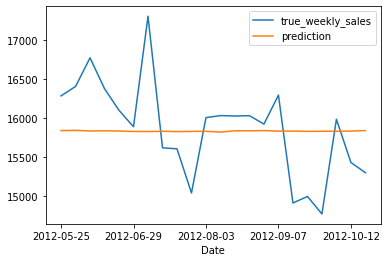

In [278]:
#transformer -마지막 층

#transformer
def trans_model(X_train, y_train, X_test, sc):

    new_model=load_model('trans_model/stock_model.h5')

    new_model.layers[3].trainable = True
    new_model.layers[2].trainable = False
    new_model.layers[1].trainable = False
    new_model.layers[0].trainable = False

    # Compiling
    new_model.compile(optimizer='adam', loss='mean_absolute_error')
    # Fitting to the training set
    new_model.fit(X_train,y_train,epochs=500, verbose=1)

    trans_prediction = new_model.predict(X_test)
    trans_prediction = sc.inverse_transform(trans_prediction)

    return new_model, trans_prediction

new_model, trans_prediction= trans_model(X_train,y_train,X_test,sc)
pred_plot(trans_prediction, y_test_reversed_2)

In [279]:
new_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 5, 1)]       0           []                               
                                                                                                  
 layer_normalization_51 (LayerN  (None, 5, 1)        2           ['input_10[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_27 (Multi  (None, 5, 1)        7169        ['layer_normalization_51[0][0]', 
 HeadAttention)                                                   'layer_normalization_51[0][0]'] 
                                                                                            

Epoch 1/500
4/4 [==============================] - 5s 18ms/step - loss: 0.1627
Epoch 2/500
4/4 [==============================] - 0s 18ms/step - loss: 0.1369
Epoch 3/500
4/4 [==============================] - 0s 19ms/step - loss: 0.1195
Epoch 4/500
4/4 [==============================] - 0s 18ms/step - loss: 0.1073
Epoch 5/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0964
Epoch 6/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0876
Epoch 7/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0777
Epoch 8/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0766
Epoch 9/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0779
Epoch 10/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0750
Epoch 11/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0748
Epoch 12/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0750
Epoch 13/500
4/4 [==============================]

(None,             true_weekly_sales    prediction
 Date                                       
 2012-05-25       16284.414590  15621.474609
 2012-06-01       16405.589439  16044.143555
 2012-06-08       16774.044520  15847.165039
 2012-06-15       16377.574662  15990.876953
 2012-06-22       16098.711574  15907.202148
 2012-06-29       15887.184494  15662.220703
 2012-07-06       17309.362337  15632.015625
 2012-07-13       15616.440413  16026.499023
 2012-07-20       15602.826372  15576.807617
 2012-07-27       15034.829516  15356.066406
 2012-08-03       16004.684719  15539.315430
 2012-08-10       16030.926967  15455.583008
 2012-08-17       16025.195279  15823.625000
 2012-08-24       16029.501216  15636.226562
 2012-08-31       15921.552812  15881.972656
 2012-09-07       16294.692957  15654.646484
 2012-09-14       14905.978648  15781.148438
 2012-09-21       14989.708385  15316.733398
 2012-09-28       14765.327279  15263.349609
 2012-10-05       15983.413747  15389.475586
 201

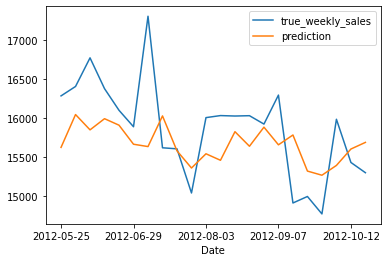

In [280]:
#transformer -마지막 2층

#transformer
def trans_model(X_train, y_train, X_test, sc):

    new_model=load_model('trans_model/stock_model.h5')

    new_model.layers[3].trainable = True
    new_model.layers[2].trainable = True
    new_model.layers[1].trainable = False
    new_model.layers[0].trainable = False

    # Compiling
    new_model.compile(optimizer='adam', loss='mean_absolute_error')
    # Fitting to the training set
    new_model.fit(X_train,y_train,epochs=500, verbose=1)

    trans_prediction = new_model.predict(X_test)
    trans_prediction = sc.inverse_transform(trans_prediction)

    return new_model, trans_prediction

new_model, trans_prediction= trans_model(X_train,y_train,X_test,sc)
pred_plot(trans_prediction, y_test_reversed_2)

In [281]:
new_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 5, 1)]       0           []                               
                                                                                                  
 layer_normalization_51 (LayerN  (None, 5, 1)        2           ['input_10[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_27 (Multi  (None, 5, 1)        7169        ['layer_normalization_51[0][0]', 
 HeadAttention)                                                   'layer_normalization_51[0][0]'] 
                                                                                            

# 결론 및 한계점

* classic 머신러닝보다 RNN을 이용한 딥러닝이 시계열 데이터에서 예측 정확성이 높다 

* 동일한 모델(LSTM)에 대해 transfer learning 전 후 성능을 비교했을 때 ,transfer learning 후에 정확도가 향상 된다.

* 완벽하게 일치하지 않은 도메인이라도 ( market sales vs stock price) trnasfer learning이 정확도 향상에 어느정도  도움이 되는 것으로 보인다.

* transfer learning 시 재 학습 층의 개수와 정확도는 정비례 하지 않는다 ( 많은 층을 재학습한다고 정확도가 올라가진 않는다)

한계점 /후속 프로젝트

* 딥러닝의 경우 하이퍼 파라미터 튜닝을 하지 않았기 때문에, 현재 mae/mse 값이 모델 간의 성능 차이를 단언할 수 없다.

* multi variate(이전 time steps의 target값이 아닌 다른 변수를 X로), 특히 해당 데이터와 correaltion이 높은 feature를 사용해 예측을 진행해보고 싶다 

* 현실에서 접할 수 있는 정말 작은 데이터 ( 1년치이지만 4-5개 밖에 없는 데이터에서도 ) 예측이 가능할지 few shot learning을 적용해 보고 싶다. -전처리 데이터 준비완료 

![image.png](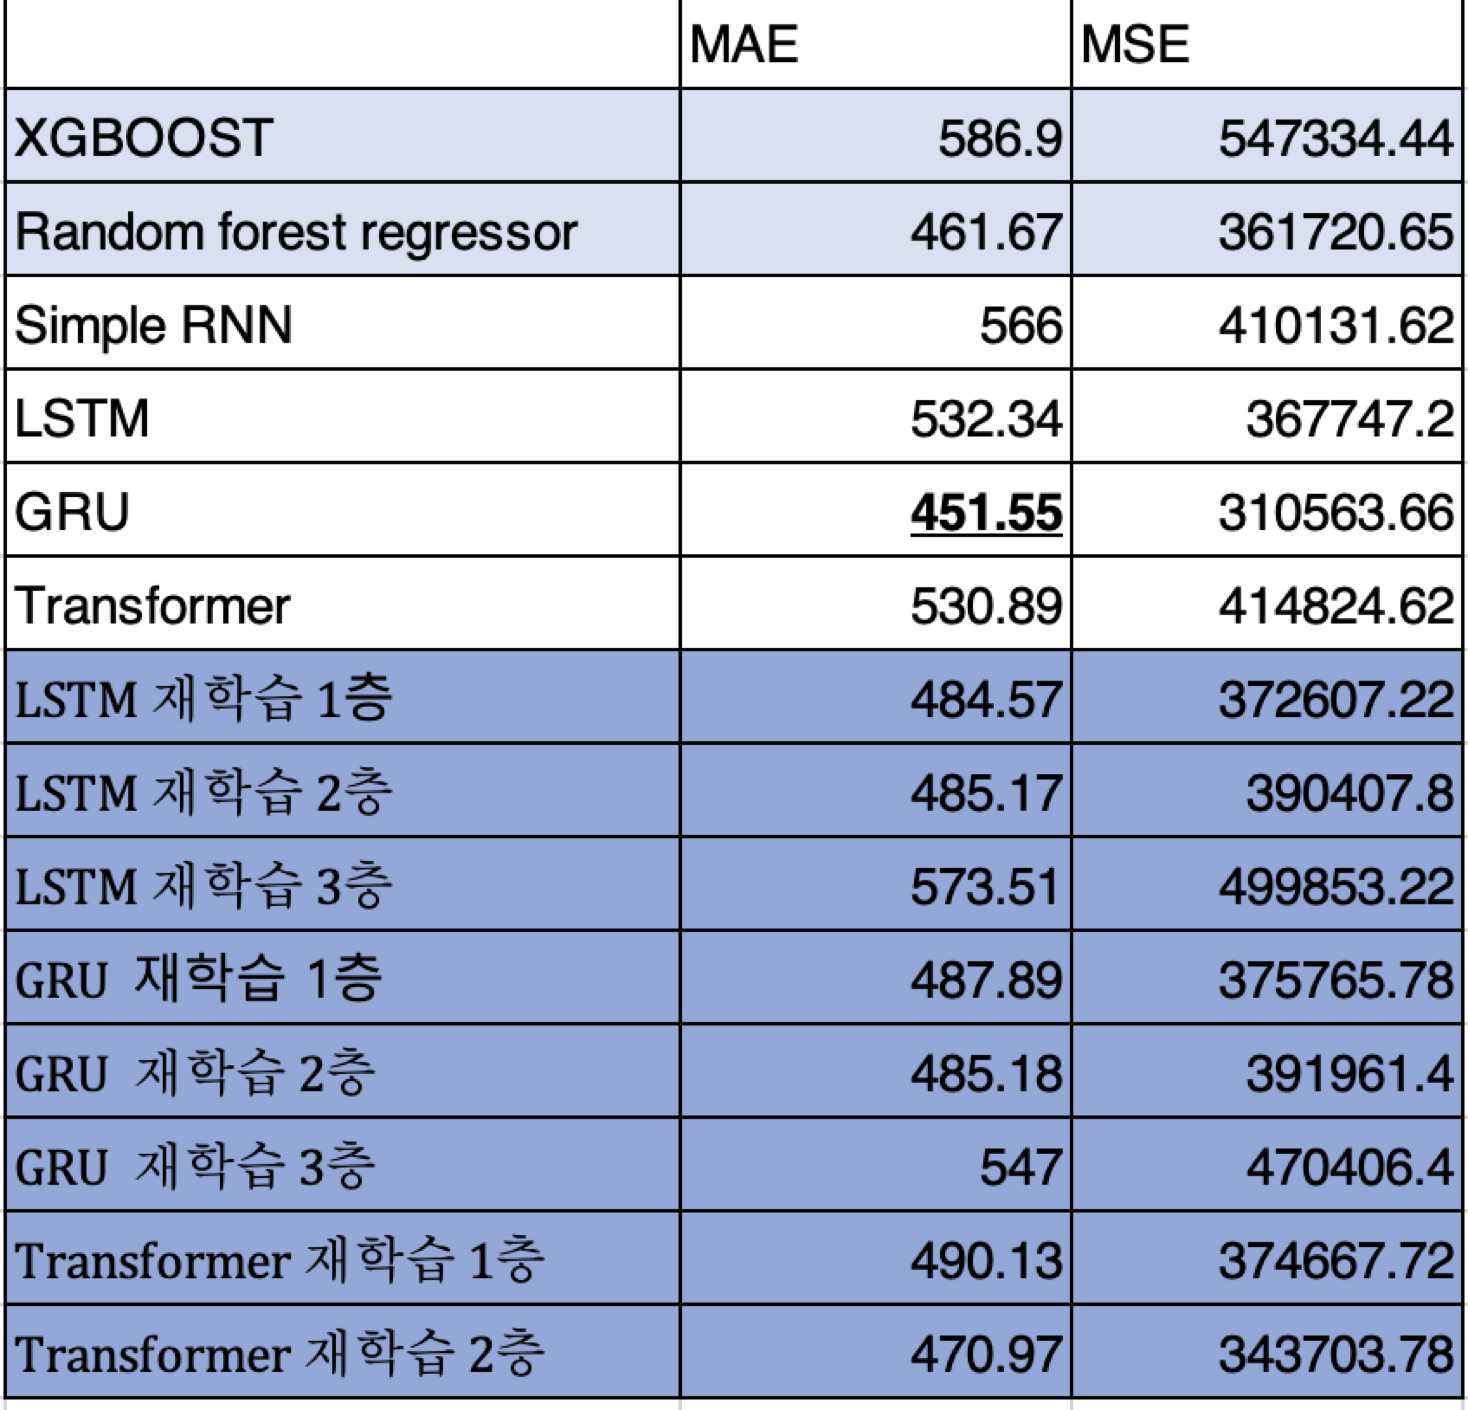AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCPgCKQRcMI7DYV/cAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBGYzAg44T2ZW8/r7gg4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCOQRsAJ7zQU/sERcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHYDIj4IT3ZG49r7sj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOQBoBJ7zTUPgHR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHIHJjIAT3pO59bzujoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAJpBJzwTkPhHxwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEJjMC/x/bcrNejGDoIQAAAABJRU5ErkJggg==)